In [1]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from common.layers import NoisyLinear
from common.replay_buffer import ReplayBuffer
import gym_Aircraft

from itertools import count
import time
import itertools
import matplotlib
import matplotlib.pyplot as plt

In [2]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

In [3]:
env_id = "acav-v0"
env = gym.make(env_id)

/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
class RainbowDQN(nn.Module):
    def __init__(self, num_inputs, num_actions, num_atoms, Vmin, Vmax):
        super(RainbowDQN, self).__init__()
        
        self.num_inputs   = num_inputs
        self.num_actions  = num_actions
        self.num_atoms    = num_atoms
        self.Vmin         = Vmin
        self.Vmax         = Vmax
        
        self.linear1 = nn.Linear(num_inputs, 32)
        self.linear2 = nn.Linear(32, 64)
        
        self.noisy_value1 = NoisyLinear(64, 64, use_cuda=USE_CUDA)
        self.noisy_value2 = NoisyLinear(64, self.num_atoms, use_cuda=USE_CUDA)
        
        self.noisy_advantage1 = NoisyLinear(64, 64, use_cuda=USE_CUDA)
        self.noisy_advantage2 = NoisyLinear(64, self.num_atoms * self.num_actions, use_cuda=USE_CUDA)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        
        value = F.relu(self.noisy_value1(x))
        value = self.noisy_value2(value)
        
        advantage = F.relu(self.noisy_advantage1(x))
        advantage = self.noisy_advantage2(advantage)
        
        value     = value.view(batch_size, 1, self.num_atoms)
        advantage = advantage.view(batch_size, self.num_actions, self.num_atoms)
        
        x = value + advantage - advantage.mean(1, keepdim=True)
        x = F.softmax(x.view(-1, self.num_atoms)).view(-1, self.num_actions, self.num_atoms)
        
        return x
        
    def reset_noise(self):
        self.noisy_value1.reset_noise()
        self.noisy_value2.reset_noise()
        self.noisy_advantage1.reset_noise()
        self.noisy_advantage2.reset_noise()
    
    def act(self, state):
        state = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
        dist = self.forward(state).data.cpu()
        dist = dist * torch.linspace(self.Vmin, self.Vmax, self.num_atoms)
        action = dist.sum(2).max(1)[1].numpy()[0]
        return action

In [5]:
num_atoms = 51
Vmin = -10
Vmax = 10

current_model = RainbowDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)
target_model  = RainbowDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), 0.001)

replay_buffer = ReplayBuffer(10000)

In [6]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())
    
update_target(current_model, target_model)

In [7]:
def projection_distribution(next_state, rewards, dones):
    batch_size  = next_state.size(0)
    
    delta_z = float(Vmax - Vmin) / (num_atoms - 1)
    support = torch.linspace(Vmin, Vmax, num_atoms)
    
    next_dist   = target_model(next_state).data.cpu() * support
    next_action = next_dist.sum(2).max(1)[1]
    next_action = next_action.unsqueeze(1).unsqueeze(1).expand(next_dist.size(0), 1, next_dist.size(2))
    next_dist   = next_dist.gather(1, next_action).squeeze(1)
        
    rewards = rewards.unsqueeze(1).expand_as(next_dist)
    dones   = dones.unsqueeze(1).expand_as(next_dist)
    support = support.unsqueeze(0).expand_as(next_dist)
    
    Tz = rewards + (1 - dones) * 0.99 * support
    Tz = Tz.clamp(min=Vmin, max=Vmax)
    b  = (Tz - Vmin) / delta_z
    l  = b.floor().long()
    u  = b.ceil().long()
        
    offset = torch.linspace(0, (batch_size - 1) * num_atoms, batch_size).long()\
                    .unsqueeze(1).expand(batch_size, num_atoms)

    proj_dist = torch.zeros(next_dist.size())    
    proj_dist.view(-1).index_add_(0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1))
    proj_dist.view(-1).index_add_(0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1))
        
    return proj_dist

In [8]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size) 

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = torch.FloatTensor(reward)
    done       = torch.FloatTensor(np.float32(done))

    proj_dist = projection_distribution(next_state, reward, done)
    
    dist = current_model(state)
    action = action.unsqueeze(1).unsqueeze(1).expand(batch_size, 1, num_atoms)
    dist = dist.gather(1, action).squeeze(1)
    dist.data.clamp_(0.01, 0.99)
    loss = -(Variable(proj_dist) * dist.log()).sum(1)
    loss  = loss.mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    current_model.reset_noise()
    target_model.reset_noise()
    
    return loss

In [9]:
num_episodes = 10000
batch_size = 32
gamma=0.99
TARGET_UPDATE=10

losses = []
total_res=[]
reward_list=[]
for i_episode in range(num_episodes):
    total_reward=0
    
    # 환경과 상태 초기화
    res_list=np.zeros(11)
    state = env.reset()

    for t in count():
        # 행동 선택과 수행
        
        action = current_model.act(state)
        
        next_state, reward, done, res = env.step(action)
        
        # 메모리에 변이 저장
        replay_buffer.push(state, action, reward, next_state, done)
        

        # 새로운 상태 관찰
        if not done:
            next_state = next_state
        else:
            next_state = None

        

        # 다음 상태로 이동
        state = next_state

     
        # Data save
        
        cmd_list,r_list,elev_list,azim_list,Pm_list,Pt_list,h_list=res
        Pm_list=Pm_list.tolist()
        Pt_list=Pt_list.tolist()
        merged_data=itertools.chain([cmd_list],[r_list],[elev_list],[azim_list],Pm_list,Pt_list,[h_list])
        merged_data=np.array(list(merged_data))
        res_list=np.vstack([res_list,merged_data])
        
        total_reward+=reward
        
        if done:
            res_list=np.delete(res_list,0,0)
            
            total_res.append(res_list)
            reward_list.append(total_reward)
            
            now = time.localtime()
            print ("%04d/%02d/%02d %02d:%02d:%02d" % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec))
            print("episode : {} | final step : {} | total reward : {}".format(i_episode, t, total_reward))
            break
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(batch_size)
            losses.append(loss.item())
            
        
    #목표 네트워크 업데이트, 모든 웨이트와 바이어스 복사
    if i_episode % TARGET_UPDATE == 0:
        update_target(current_model, target_model)

print('Complete')
env.close()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


2020/10/04 23:44:37
episode : 0 | final step : 100 | total reward : 61.28215345447158
2020/10/04 23:44:38
episode : 1 | final step : 98 | total reward : -55.0
2020/10/04 23:44:39
episode : 2 | final step : 99 | total reward : -51.0
2020/10/04 23:44:40
episode : 3 | final step : 98 | total reward : -53.0
2020/10/04 23:44:41
episode : 4 | final step : 97 | total reward : -51.0
2020/10/04 23:44:42
episode : 5 | final step : 98 | total reward : -51.0
2020/10/04 23:44:43
episode : 6 | final step : 99 | total reward : -51.0
2020/10/04 23:44:44
episode : 7 | final step : 98 | total reward : -51.0
2020/10/04 23:44:45
episode : 8 | final step : 99 | total reward : -51.0
2020/10/04 23:44:47
episode : 9 | final step : 99 | total reward : -51.0
2020/10/04 23:44:48
episode : 10 | final step : 98 | total reward : -51.0
2020/10/04 23:44:49
episode : 11 | final step : 101 | total reward : 95.37009580817767
2020/10/04 23:44:50
episode : 12 | final step : 98 | total reward : -52.0
2020/10/04 23:44:51
ep

2020/10/04 23:46:38
episode : 108 | final step : 97 | total reward : -50.0
2020/10/04 23:46:39
episode : 109 | final step : 101 | total reward : 99.90289450863169
2020/10/04 23:46:40
episode : 110 | final step : 99 | total reward : -50.0
2020/10/04 23:46:41
episode : 111 | final step : 99 | total reward : -50.0
2020/10/04 23:46:42
episode : 112 | final step : 99 | total reward : 99.15816112125763
2020/10/04 23:46:43
episode : 113 | final step : 98 | total reward : -50.0
2020/10/04 23:46:44
episode : 114 | final step : 98 | total reward : -50.0
2020/10/04 23:46:45
episode : 115 | final step : 98 | total reward : -50.0
2020/10/04 23:46:46
episode : 116 | final step : 101 | total reward : 92.1200018848245
2020/10/04 23:46:47
episode : 117 | final step : 98 | total reward : -50.0
2020/10/04 23:46:48
episode : 118 | final step : 98 | total reward : -50.0
2020/10/04 23:46:49
episode : 119 | final step : 98 | total reward : -50.0
2020/10/04 23:46:50
episode : 120 | final step : 103 | total re

2020/10/04 23:48:33
episode : 215 | final step : 98 | total reward : -50.0
2020/10/04 23:48:35
episode : 216 | final step : 98 | total reward : -50.0
2020/10/04 23:48:36
episode : 217 | final step : 98 | total reward : -50.0
2020/10/04 23:48:37
episode : 218 | final step : 98 | total reward : -50.0
2020/10/04 23:48:38
episode : 219 | final step : 98 | total reward : -50.0
2020/10/04 23:48:39
episode : 220 | final step : 98 | total reward : -50.0
2020/10/04 23:48:41
episode : 221 | final step : 100 | total reward : -50.0
2020/10/04 23:48:42
episode : 222 | final step : 98 | total reward : -50.0
2020/10/04 23:48:43
episode : 223 | final step : 98 | total reward : -50.0
2020/10/04 23:48:44
episode : 224 | final step : 98 | total reward : -50.0
2020/10/04 23:48:45
episode : 225 | final step : 98 | total reward : -50.0
2020/10/04 23:48:47
episode : 226 | final step : 99 | total reward : -50.0
2020/10/04 23:48:48
episode : 227 | final step : 98 | total reward : -50.0
2020/10/04 23:48:49
epis

2020/10/04 23:50:37
episode : 322 | final step : 102 | total reward : 98.67066919228722
2020/10/04 23:50:38
episode : 323 | final step : 98 | total reward : -50.0
2020/10/04 23:50:39
episode : 324 | final step : 98 | total reward : -50.0
2020/10/04 23:50:40
episode : 325 | final step : 98 | total reward : -50.0
2020/10/04 23:50:41
episode : 326 | final step : 98 | total reward : -50.0
2020/10/04 23:50:42
episode : 327 | final step : 98 | total reward : -50.0
2020/10/04 23:50:43
episode : 328 | final step : 97 | total reward : -50.0
2020/10/04 23:50:45
episode : 329 | final step : 98 | total reward : -50.0
2020/10/04 23:50:46
episode : 330 | final step : 98 | total reward : -50.0
2020/10/04 23:50:47
episode : 331 | final step : 104 | total reward : 87.83403003608574
2020/10/04 23:50:48
episode : 332 | final step : 98 | total reward : -50.0
2020/10/04 23:50:49
episode : 333 | final step : 98 | total reward : -50.0
2020/10/04 23:50:50
episode : 334 | final step : 98 | total reward : -50.0

2020/10/04 23:52:39
episode : 429 | final step : 98 | total reward : -50.0
2020/10/04 23:52:40
episode : 430 | final step : 100 | total reward : 99.61204647652706
2020/10/04 23:52:41
episode : 431 | final step : 98 | total reward : -50.0
2020/10/04 23:52:42
episode : 432 | final step : 98 | total reward : -50.0
2020/10/04 23:52:43
episode : 433 | final step : 99 | total reward : -50.0
2020/10/04 23:52:44
episode : 434 | final step : 98 | total reward : -50.0
2020/10/04 23:52:46
episode : 435 | final step : 98 | total reward : -50.0
2020/10/04 23:52:47
episode : 436 | final step : 98 | total reward : -50.0
2020/10/04 23:52:48
episode : 437 | final step : 100 | total reward : 99.82141313438686
2020/10/04 23:52:49
episode : 438 | final step : 99 | total reward : -50.0
2020/10/04 23:52:50
episode : 439 | final step : 98 | total reward : -50.0
2020/10/04 23:52:51
episode : 440 | final step : 97 | total reward : -50.0
2020/10/04 23:52:52
episode : 441 | final step : 99 | total reward : -50.0

2020/10/04 23:54:44
episode : 536 | final step : 103 | total reward : 97.50406765920742
2020/10/04 23:54:45
episode : 537 | final step : 97 | total reward : -50.0
2020/10/04 23:54:46
episode : 538 | final step : 98 | total reward : -50.0
2020/10/04 23:54:47
episode : 539 | final step : 98 | total reward : -50.0
2020/10/04 23:54:48
episode : 540 | final step : 98 | total reward : -50.0
2020/10/04 23:54:49
episode : 541 | final step : 98 | total reward : -50.0
2020/10/04 23:54:51
episode : 542 | final step : 98 | total reward : -50.0
2020/10/04 23:54:52
episode : 543 | final step : 103 | total reward : 87.00798882017625
2020/10/04 23:54:53
episode : 544 | final step : 98 | total reward : -50.0
2020/10/04 23:54:54
episode : 545 | final step : 98 | total reward : -50.0
2020/10/04 23:54:55
episode : 546 | final step : 98 | total reward : -50.0
2020/10/04 23:54:56
episode : 547 | final step : 99 | total reward : -50.0
2020/10/04 23:54:58
episode : 548 | final step : 97 | total reward : -50.0

2020/10/04 23:56:49
episode : 644 | final step : 97 | total reward : -50.0
2020/10/04 23:56:50
episode : 645 | final step : 98 | total reward : -50.0
2020/10/04 23:56:51
episode : 646 | final step : 98 | total reward : -50.0
2020/10/04 23:56:52
episode : 647 | final step : 98 | total reward : -50.0
2020/10/04 23:56:53
episode : 648 | final step : 98 | total reward : -50.0
2020/10/04 23:56:54
episode : 649 | final step : 98 | total reward : -50.0
2020/10/04 23:56:55
episode : 650 | final step : 98 | total reward : -50.0
2020/10/04 23:56:57
episode : 651 | final step : 98 | total reward : -50.0
2020/10/04 23:56:58
episode : 652 | final step : 98 | total reward : -50.0
2020/10/04 23:56:59
episode : 653 | final step : 103 | total reward : 96.49679710263995
2020/10/04 23:57:00
episode : 654 | final step : 98 | total reward : -50.0
2020/10/04 23:57:02
episode : 655 | final step : 99 | total reward : -50.0
2020/10/04 23:57:03
episode : 656 | final step : 98 | total reward : -50.0
2020/10/04 2

2020/10/04 23:58:51
episode : 751 | final step : 99 | total reward : -50.0
2020/10/04 23:58:52
episode : 752 | final step : 97 | total reward : -50.0
2020/10/04 23:58:54
episode : 753 | final step : 98 | total reward : -50.0
2020/10/04 23:58:55
episode : 754 | final step : 98 | total reward : 85.43397966702153
2020/10/04 23:58:56
episode : 755 | final step : 101 | total reward : -50.0
2020/10/04 23:58:58
episode : 756 | final step : 98 | total reward : -50.0
2020/10/04 23:58:59
episode : 757 | final step : 98 | total reward : -50.0
2020/10/04 23:59:00
episode : 758 | final step : 98 | total reward : -50.0
2020/10/04 23:59:01
episode : 759 | final step : 98 | total reward : 98.10384663694488
2020/10/04 23:59:02
episode : 760 | final step : 98 | total reward : -50.0
2020/10/04 23:59:03
episode : 761 | final step : 98 | total reward : -50.0
2020/10/04 23:59:05
episode : 762 | final step : 103 | total reward : 97.34721630477593
2020/10/04 23:59:06
episode : 763 | final step : 98 | total re

2020/10/05 00:00:54
episode : 858 | final step : 98 | total reward : -50.0
2020/10/05 00:00:55
episode : 859 | final step : 97 | total reward : -50.0
2020/10/05 00:00:56
episode : 860 | final step : 98 | total reward : -50.0
2020/10/05 00:00:58
episode : 861 | final step : 98 | total reward : -50.0
2020/10/05 00:00:59
episode : 862 | final step : 98 | total reward : -50.0
2020/10/05 00:01:00
episode : 863 | final step : 99 | total reward : -50.0
2020/10/05 00:01:01
episode : 864 | final step : 98 | total reward : -50.0
2020/10/05 00:01:02
episode : 865 | final step : 98 | total reward : -50.0
2020/10/05 00:01:03
episode : 866 | final step : 97 | total reward : -50.0
2020/10/05 00:01:04
episode : 867 | final step : 98 | total reward : -50.0
2020/10/05 00:01:06
episode : 868 | final step : 98 | total reward : -50.0
2020/10/05 00:01:07
episode : 869 | final step : 98 | total reward : -50.0
2020/10/05 00:01:08
episode : 870 | final step : 98 | total reward : -50.0
2020/10/05 00:01:10
episo

2020/10/05 00:02:59
episode : 966 | final step : 99 | total reward : -50.0
2020/10/05 00:03:00
episode : 967 | final step : 98 | total reward : -50.0
2020/10/05 00:03:01
episode : 968 | final step : 98 | total reward : -50.0
2020/10/05 00:03:02
episode : 969 | final step : 98 | total reward : -50.0
2020/10/05 00:03:03
episode : 970 | final step : 98 | total reward : -50.0
2020/10/05 00:03:05
episode : 971 | final step : 102 | total reward : 95.36010621659366
2020/10/05 00:03:06
episode : 972 | final step : 99 | total reward : -50.0
2020/10/05 00:03:07
episode : 973 | final step : 99 | total reward : 99.13222523792375
2020/10/05 00:03:08
episode : 974 | final step : 98 | total reward : -50.0
2020/10/05 00:03:09
episode : 975 | final step : 98 | total reward : -50.0
2020/10/05 00:03:10
episode : 976 | final step : 98 | total reward : -50.0
2020/10/05 00:03:11
episode : 977 | final step : 99 | total reward : -50.0
2020/10/05 00:03:12
episode : 978 | final step : 98 | total reward : -50.0


2020/10/05 00:05:05
episode : 1073 | final step : 98 | total reward : -50.0
2020/10/05 00:05:06
episode : 1074 | final step : 98 | total reward : -50.0
2020/10/05 00:05:07
episode : 1075 | final step : 98 | total reward : -50.0
2020/10/05 00:05:09
episode : 1076 | final step : 98 | total reward : -50.0
2020/10/05 00:05:10
episode : 1077 | final step : 99 | total reward : -50.0
2020/10/05 00:05:11
episode : 1078 | final step : 98 | total reward : -50.0
2020/10/05 00:05:12
episode : 1079 | final step : 99 | total reward : -50.0
2020/10/05 00:05:13
episode : 1080 | final step : 98 | total reward : -50.0
2020/10/05 00:05:14
episode : 1081 | final step : 98 | total reward : -50.0
2020/10/05 00:05:15
episode : 1082 | final step : 98 | total reward : -50.0
2020/10/05 00:05:16
episode : 1083 | final step : 99 | total reward : -50.0
2020/10/05 00:05:17
episode : 1084 | final step : 99 | total reward : -50.0
2020/10/05 00:05:18
episode : 1085 | final step : 98 | total reward : 94.6050718870501
2

2020/10/05 00:07:08
episode : 1180 | final step : 98 | total reward : -50.0
2020/10/05 00:07:09
episode : 1181 | final step : 102 | total reward : 98.30148412245019
2020/10/05 00:07:10
episode : 1182 | final step : 100 | total reward : 98.94193198203214
2020/10/05 00:07:12
episode : 1183 | final step : 99 | total reward : -50.0
2020/10/05 00:07:13
episode : 1184 | final step : 98 | total reward : -50.0
2020/10/05 00:07:14
episode : 1185 | final step : 98 | total reward : -50.0
2020/10/05 00:07:15
episode : 1186 | final step : 99 | total reward : -50.0
2020/10/05 00:07:16
episode : 1187 | final step : 98 | total reward : -50.0
2020/10/05 00:07:17
episode : 1188 | final step : 98 | total reward : -50.0
2020/10/05 00:07:18
episode : 1189 | final step : 98 | total reward : -50.0
2020/10/05 00:07:19
episode : 1190 | final step : 98 | total reward : -50.0
2020/10/05 00:07:20
episode : 1191 | final step : 98 | total reward : -50.0
2020/10/05 00:07:22
episode : 1192 | final step : 99 | total r

2020/10/05 00:09:10
episode : 1286 | final step : 98 | total reward : -50.0
2020/10/05 00:09:11
episode : 1287 | final step : 98 | total reward : -50.0
2020/10/05 00:09:13
episode : 1288 | final step : 98 | total reward : -50.0
2020/10/05 00:09:14
episode : 1289 | final step : 98 | total reward : -50.0
2020/10/05 00:09:15
episode : 1290 | final step : 98 | total reward : -50.0
2020/10/05 00:09:16
episode : 1291 | final step : 101 | total reward : 98.63182355172052
2020/10/05 00:09:17
episode : 1292 | final step : 98 | total reward : -50.0
2020/10/05 00:09:18
episode : 1293 | final step : 100 | total reward : -50.0
2020/10/05 00:09:19
episode : 1294 | final step : 98 | total reward : -50.0
2020/10/05 00:09:21
episode : 1295 | final step : 98 | total reward : -50.0
2020/10/05 00:09:22
episode : 1296 | final step : 98 | total reward : -50.0
2020/10/05 00:09:23
episode : 1297 | final step : 97 | total reward : -50.0
2020/10/05 00:09:25
episode : 1298 | final step : 98 | total reward : -50.

2020/10/05 00:11:14
episode : 1393 | final step : 98 | total reward : -50.0
2020/10/05 00:11:15
episode : 1394 | final step : 98 | total reward : -50.0
2020/10/05 00:11:16
episode : 1395 | final step : 98 | total reward : -50.0
2020/10/05 00:11:17
episode : 1396 | final step : 100 | total reward : 97.03411154120775
2020/10/05 00:11:18
episode : 1397 | final step : 98 | total reward : -50.0
2020/10/05 00:11:20
episode : 1398 | final step : 99 | total reward : -50.0
2020/10/05 00:11:21
episode : 1399 | final step : 98 | total reward : -50.0
2020/10/05 00:11:22
episode : 1400 | final step : 98 | total reward : 96.01986545680458
2020/10/05 00:11:24
episode : 1401 | final step : 98 | total reward : -50.0
2020/10/05 00:11:25
episode : 1402 | final step : 98 | total reward : 85.13694383663899
2020/10/05 00:11:26
episode : 1403 | final step : 98 | total reward : -50.0
2020/10/05 00:11:27
episode : 1404 | final step : 103 | total reward : 90.525303281842
2020/10/05 00:11:29
episode : 1405 | fin

2020/10/05 00:13:17
episode : 1498 | final step : 97 | total reward : -50.0
2020/10/05 00:13:18
episode : 1499 | final step : 98 | total reward : -50.0
2020/10/05 00:13:19
episode : 1500 | final step : 98 | total reward : -50.0
2020/10/05 00:13:20
episode : 1501 | final step : 98 | total reward : -50.0
2020/10/05 00:13:21
episode : 1502 | final step : 99 | total reward : -50.0
2020/10/05 00:13:22
episode : 1503 | final step : 98 | total reward : -50.0
2020/10/05 00:13:23
episode : 1504 | final step : 98 | total reward : -50.0
2020/10/05 00:13:24
episode : 1505 | final step : 99 | total reward : -50.0
2020/10/05 00:13:26
episode : 1506 | final step : 98 | total reward : -50.0
2020/10/05 00:13:27
episode : 1507 | final step : 98 | total reward : -50.0
2020/10/05 00:13:28
episode : 1508 | final step : 100 | total reward : 99.89863826134419
2020/10/05 00:13:30
episode : 1509 | final step : 99 | total reward : -50.0
2020/10/05 00:13:31
episode : 1510 | final step : 103 | total reward : 95.3

2020/10/05 00:15:12
episode : 1603 | final step : 98 | total reward : -50.0
2020/10/05 00:15:13
episode : 1604 | final step : 98 | total reward : -50.0
2020/10/05 00:15:14
episode : 1605 | final step : 98 | total reward : -50.0
2020/10/05 00:15:15
episode : 1606 | final step : 98 | total reward : -50.0
2020/10/05 00:15:16
episode : 1607 | final step : 98 | total reward : -50.0
2020/10/05 00:15:17
episode : 1608 | final step : 100 | total reward : 99.22148739470299
2020/10/05 00:15:18
episode : 1609 | final step : 98 | total reward : -50.0
2020/10/05 00:15:19
episode : 1610 | final step : 101 | total reward : 95.68609839323862
2020/10/05 00:15:21
episode : 1611 | final step : 98 | total reward : -50.0
2020/10/05 00:15:22
episode : 1612 | final step : 98 | total reward : -50.0
2020/10/05 00:15:23
episode : 1613 | final step : 99 | total reward : -50.0
2020/10/05 00:15:24
episode : 1614 | final step : 98 | total reward : -50.0
2020/10/05 00:15:25
episode : 1615 | final step : 98 | total r

2020/10/05 00:17:12
episode : 1708 | final step : 98 | total reward : -50.0
2020/10/05 00:17:13
episode : 1709 | final step : 98 | total reward : -50.0
2020/10/05 00:17:14
episode : 1710 | final step : 98 | total reward : -50.0
2020/10/05 00:17:16
episode : 1711 | final step : 99 | total reward : -51.0
2020/10/05 00:17:17
episode : 1712 | final step : 99 | total reward : -50.0
2020/10/05 00:17:18
episode : 1713 | final step : 98 | total reward : -50.0
2020/10/05 00:17:19
episode : 1714 | final step : 98 | total reward : -50.0
2020/10/05 00:17:20
episode : 1715 | final step : 98 | total reward : 99.68150395649506
2020/10/05 00:17:21
episode : 1716 | final step : 98 | total reward : -50.0
2020/10/05 00:17:22
episode : 1717 | final step : 98 | total reward : -50.0
2020/10/05 00:17:24
episode : 1718 | final step : 98 | total reward : 99.48256987754928
2020/10/05 00:17:25
episode : 1719 | final step : 98 | total reward : -50.0
2020/10/05 00:17:26
episode : 1720 | final step : 100 | total re

2020/10/05 00:19:14
episode : 1813 | final step : 98 | total reward : -50.0
2020/10/05 00:19:16
episode : 1814 | final step : 98 | total reward : -50.0
2020/10/05 00:19:17
episode : 1815 | final step : 98 | total reward : -50.0
2020/10/05 00:19:18
episode : 1816 | final step : 98 | total reward : -51.0
2020/10/05 00:19:19
episode : 1817 | final step : 98 | total reward : -50.0
2020/10/05 00:19:20
episode : 1818 | final step : 98 | total reward : -50.0
2020/10/05 00:19:21
episode : 1819 | final step : 99 | total reward : -50.0
2020/10/05 00:19:22
episode : 1820 | final step : 98 | total reward : -50.0
2020/10/05 00:19:24
episode : 1821 | final step : 98 | total reward : -50.0
2020/10/05 00:19:25
episode : 1822 | final step : 98 | total reward : -50.0
2020/10/05 00:19:26
episode : 1823 | final step : 99 | total reward : -50.0
2020/10/05 00:19:27
episode : 1824 | final step : 98 | total reward : -50.0
2020/10/05 00:19:28
episode : 1825 | final step : 98 | total reward : -50.0
2020/10/05 0

2020/10/05 00:21:20
episode : 1920 | final step : 100 | total reward : 88.13567459937833
2020/10/05 00:21:21
episode : 1921 | final step : 99 | total reward : -50.0
2020/10/05 00:21:23
episode : 1922 | final step : 98 | total reward : -50.0
2020/10/05 00:21:24
episode : 1923 | final step : 98 | total reward : -50.0
2020/10/05 00:21:25
episode : 1924 | final step : 98 | total reward : -50.0
2020/10/05 00:21:26
episode : 1925 | final step : 98 | total reward : -50.0
2020/10/05 00:21:27
episode : 1926 | final step : 98 | total reward : -50.0
2020/10/05 00:21:28
episode : 1927 | final step : 98 | total reward : -50.0
2020/10/05 00:21:29
episode : 1928 | final step : 99 | total reward : -50.0
2020/10/05 00:21:31
episode : 1929 | final step : 99 | total reward : -50.0
2020/10/05 00:21:32
episode : 1930 | final step : 98 | total reward : -50.0
2020/10/05 00:21:33
episode : 1931 | final step : 103 | total reward : 97.39554721591891
2020/10/05 00:21:34
episode : 1932 | final step : 98 | total r

2020/10/05 00:23:20
episode : 2025 | final step : 98 | total reward : -50.0
2020/10/05 00:23:22
episode : 2026 | final step : 98 | total reward : -50.0
2020/10/05 00:23:23
episode : 2027 | final step : 98 | total reward : -50.0
2020/10/05 00:23:24
episode : 2028 | final step : 98 | total reward : -50.0
2020/10/05 00:23:25
episode : 2029 | final step : 98 | total reward : -50.0
2020/10/05 00:23:26
episode : 2030 | final step : 98 | total reward : -50.0
2020/10/05 00:23:27
episode : 2031 | final step : 98 | total reward : -50.0
2020/10/05 00:23:29
episode : 2032 | final step : 102 | total reward : 99.24026625939574
2020/10/05 00:23:30
episode : 2033 | final step : 102 | total reward : 93.70052151661332
2020/10/05 00:23:31
episode : 2034 | final step : 100 | total reward : 99.52041843834688
2020/10/05 00:23:33
episode : 2035 | final step : 99 | total reward : -50.0
2020/10/05 00:23:34
episode : 2036 | final step : 98 | total reward : -50.0
2020/10/05 00:23:35
episode : 2037 | final step :

2020/10/05 00:25:26
episode : 2131 | final step : 98 | total reward : -50.0
2020/10/05 00:25:28
episode : 2132 | final step : 99 | total reward : -50.0
2020/10/05 00:25:29
episode : 2133 | final step : 98 | total reward : -50.0
2020/10/05 00:25:31
episode : 2134 | final step : 98 | total reward : -50.0
2020/10/05 00:25:33
episode : 2135 | final step : 98 | total reward : -50.0
2020/10/05 00:25:36
episode : 2136 | final step : 98 | total reward : -50.0
2020/10/05 00:25:39
episode : 2137 | final step : 98 | total reward : -50.0
2020/10/05 00:25:43
episode : 2138 | final step : 98 | total reward : -50.0
2020/10/05 00:25:46
episode : 2139 | final step : 98 | total reward : -50.0
2020/10/05 00:25:49
episode : 2140 | final step : 98 | total reward : -50.0
2020/10/05 00:25:52
episode : 2141 | final step : 98 | total reward : -50.0
2020/10/05 00:25:56
episode : 2142 | final step : 98 | total reward : -50.0
2020/10/05 00:25:59
episode : 2143 | final step : 98 | total reward : -50.0
2020/10/05 0

2020/10/05 00:31:04
episode : 2237 | final step : 100 | total reward : -50.0
2020/10/05 00:31:08
episode : 2238 | final step : 98 | total reward : -50.0
2020/10/05 00:31:11
episode : 2239 | final step : 98 | total reward : -50.0
2020/10/05 00:31:14
episode : 2240 | final step : 98 | total reward : -50.0
2020/10/05 00:31:17
episode : 2241 | final step : 98 | total reward : -50.0
2020/10/05 00:31:21
episode : 2242 | final step : 98 | total reward : -50.0
2020/10/05 00:31:24
episode : 2243 | final step : 98 | total reward : 98.66272346915294
2020/10/05 00:31:28
episode : 2244 | final step : 98 | total reward : -51.0
2020/10/05 00:31:31
episode : 2245 | final step : 98 | total reward : -50.0
2020/10/05 00:31:34
episode : 2246 | final step : 98 | total reward : -50.0
2020/10/05 00:31:37
episode : 2247 | final step : 98 | total reward : -50.0
2020/10/05 00:31:40
episode : 2248 | final step : 99 | total reward : 97.1341982021888
2020/10/05 00:31:43
episode : 2249 | final step : 98 | total rew

2020/10/05 00:36:46
episode : 2343 | final step : 98 | total reward : -50.0
2020/10/05 00:36:49
episode : 2344 | final step : 102 | total reward : 96.5650522666636
2020/10/05 00:36:52
episode : 2345 | final step : 98 | total reward : -50.0
2020/10/05 00:36:56
episode : 2346 | final step : 99 | total reward : -50.0
2020/10/05 00:36:59
episode : 2347 | final step : 98 | total reward : -50.0
2020/10/05 00:37:02
episode : 2348 | final step : 98 | total reward : -50.0
2020/10/05 00:37:06
episode : 2349 | final step : 98 | total reward : -50.0
2020/10/05 00:37:09
episode : 2350 | final step : 98 | total reward : -50.0
2020/10/05 00:37:12
episode : 2351 | final step : 100 | total reward : -50.0
2020/10/05 00:37:16
episode : 2352 | final step : 99 | total reward : 98.51918613601053
2020/10/05 00:37:19
episode : 2353 | final step : 98 | total reward : -50.0
2020/10/05 00:37:22
episode : 2354 | final step : 98 | total reward : -50.0
2020/10/05 00:37:25
episode : 2355 | final step : 100 | total r

2020/10/05 00:42:32
episode : 2449 | final step : 100 | total reward : -50.0
2020/10/05 00:42:36
episode : 2450 | final step : 98 | total reward : -50.0
2020/10/05 00:42:39
episode : 2451 | final step : 98 | total reward : -50.0
2020/10/05 00:42:42
episode : 2452 | final step : 98 | total reward : 95.99671244787143
2020/10/05 00:42:46
episode : 2453 | final step : 98 | total reward : -50.0
2020/10/05 00:42:49
episode : 2454 | final step : 98 | total reward : -50.0
2020/10/05 00:42:52
episode : 2455 | final step : 98 | total reward : -51.0
2020/10/05 00:42:55
episode : 2456 | final step : 99 | total reward : -50.0
2020/10/05 00:42:58
episode : 2457 | final step : 97 | total reward : -50.0
2020/10/05 00:43:01
episode : 2458 | final step : 98 | total reward : -50.0
2020/10/05 00:43:05
episode : 2459 | final step : 98 | total reward : -50.0
2020/10/05 00:43:08
episode : 2460 | final step : 98 | total reward : -50.0
2020/10/05 00:43:11
episode : 2461 | final step : 98 | total reward : -50.0

2020/10/05 00:48:14
episode : 2555 | final step : 98 | total reward : -50.0
2020/10/05 00:48:18
episode : 2556 | final step : 98 | total reward : -50.0
2020/10/05 00:48:21
episode : 2557 | final step : 104 | total reward : 91.58207057935054
2020/10/05 00:48:24
episode : 2558 | final step : 98 | total reward : -50.0
2020/10/05 00:48:28
episode : 2559 | final step : 98 | total reward : -50.0
2020/10/05 00:48:31
episode : 2560 | final step : 98 | total reward : -50.0
2020/10/05 00:48:34
episode : 2561 | final step : 100 | total reward : -51.0
2020/10/05 00:48:37
episode : 2562 | final step : 98 | total reward : -50.0
2020/10/05 00:48:40
episode : 2563 | final step : 99 | total reward : 99.99901319394701
2020/10/05 00:48:43
episode : 2564 | final step : 98 | total reward : -50.0
2020/10/05 00:48:47
episode : 2565 | final step : 98 | total reward : -50.0
2020/10/05 00:48:50
episode : 2566 | final step : 99 | total reward : -50.0
2020/10/05 00:48:53
episode : 2567 | final step : 99 | total r

2020/10/05 00:53:54
episode : 2661 | final step : 99 | total reward : -50.0
2020/10/05 00:53:57
episode : 2662 | final step : 99 | total reward : -50.0
2020/10/05 00:54:00
episode : 2663 | final step : 97 | total reward : -50.0
2020/10/05 00:54:04
episode : 2664 | final step : 98 | total reward : 99.16782504956835
2020/10/05 00:54:07
episode : 2665 | final step : 100 | total reward : -50.0
2020/10/05 00:54:10
episode : 2666 | final step : 98 | total reward : -50.0
2020/10/05 00:54:13
episode : 2667 | final step : 98 | total reward : -50.0
2020/10/05 00:54:17
episode : 2668 | final step : 98 | total reward : -50.0
2020/10/05 00:54:20
episode : 2669 | final step : 99 | total reward : -50.0
2020/10/05 00:54:23
episode : 2670 | final step : 98 | total reward : -50.0
2020/10/05 00:54:26
episode : 2671 | final step : 98 | total reward : -51.0
2020/10/05 00:54:30
episode : 2672 | final step : 97 | total reward : -50.0
2020/10/05 00:54:33
episode : 2673 | final step : 99 | total reward : 97.18

2020/10/05 00:59:32
episode : 2766 | final step : 97 | total reward : -50.0
2020/10/05 00:59:35
episode : 2767 | final step : 98 | total reward : -50.0
2020/10/05 00:59:39
episode : 2768 | final step : 99 | total reward : -50.0
2020/10/05 00:59:42
episode : 2769 | final step : 98 | total reward : -50.0
2020/10/05 00:59:45
episode : 2770 | final step : 97 | total reward : -50.0
2020/10/05 00:59:48
episode : 2771 | final step : 98 | total reward : -50.0
2020/10/05 00:59:51
episode : 2772 | final step : 98 | total reward : -50.0
2020/10/05 00:59:54
episode : 2773 | final step : 97 | total reward : -50.0
2020/10/05 00:59:58
episode : 2774 | final step : 98 | total reward : -50.0
2020/10/05 01:00:01
episode : 2775 | final step : 102 | total reward : 91.28410226993262
2020/10/05 01:00:04
episode : 2776 | final step : 100 | total reward : 89.63846023807515
2020/10/05 01:00:07
episode : 2777 | final step : 98 | total reward : -50.0
2020/10/05 01:00:10
episode : 2778 | final step : 100 | total 

2020/10/05 01:05:12
episode : 2871 | final step : 99 | total reward : -50.0
2020/10/05 01:05:15
episode : 2872 | final step : 98 | total reward : -50.0
2020/10/05 01:05:18
episode : 2873 | final step : 97 | total reward : -50.0
2020/10/05 01:05:21
episode : 2874 | final step : 100 | total reward : 99.41481950613307
2020/10/05 01:05:24
episode : 2875 | final step : 97 | total reward : -50.0
2020/10/05 01:05:27
episode : 2876 | final step : 99 | total reward : -50.0
2020/10/05 01:05:31
episode : 2877 | final step : 97 | total reward : -50.0
2020/10/05 01:05:34
episode : 2878 | final step : 99 | total reward : -50.0
2020/10/05 01:05:37
episode : 2879 | final step : 98 | total reward : -50.0
2020/10/05 01:05:40
episode : 2880 | final step : 98 | total reward : -50.0
2020/10/05 01:05:44
episode : 2881 | final step : 100 | total reward : 99.51322564954955
2020/10/05 01:05:47
episode : 2882 | final step : 98 | total reward : -50.0
2020/10/05 01:05:50
episode : 2883 | final step : 99 | total r

2020/10/05 01:10:55
episode : 2977 | final step : 98 | total reward : -50.0
2020/10/05 01:10:59
episode : 2978 | final step : 100 | total reward : -50.0
2020/10/05 01:11:02
episode : 2979 | final step : 98 | total reward : -50.0
2020/10/05 01:11:05
episode : 2980 | final step : 98 | total reward : -50.0
2020/10/05 01:11:08
episode : 2981 | final step : 98 | total reward : -50.0
2020/10/05 01:11:11
episode : 2982 | final step : 99 | total reward : -50.0
2020/10/05 01:11:14
episode : 2983 | final step : 98 | total reward : -50.0
2020/10/05 01:11:18
episode : 2984 | final step : 98 | total reward : -50.0
2020/10/05 01:11:21
episode : 2985 | final step : 98 | total reward : -50.0
2020/10/05 01:11:24
episode : 2986 | final step : 98 | total reward : -50.0
2020/10/05 01:11:28
episode : 2987 | final step : 98 | total reward : -50.0
2020/10/05 01:11:31
episode : 2988 | final step : 98 | total reward : -50.0
2020/10/05 01:11:34
episode : 2989 | final step : 98 | total reward : -50.0
2020/10/05 

2020/10/05 01:16:43
episode : 3083 | final step : 97 | total reward : -50.0
2020/10/05 01:16:46
episode : 3084 | final step : 98 | total reward : -50.0
2020/10/05 01:16:49
episode : 3085 | final step : 98 | total reward : -50.0
2020/10/05 01:16:52
episode : 3086 | final step : 99 | total reward : -50.0
2020/10/05 01:16:55
episode : 3087 | final step : 98 | total reward : -50.0
2020/10/05 01:16:59
episode : 3088 | final step : 99 | total reward : -50.0
2020/10/05 01:17:02
episode : 3089 | final step : 97 | total reward : -50.0
2020/10/05 01:17:05
episode : 3090 | final step : 98 | total reward : -50.0
2020/10/05 01:17:09
episode : 3091 | final step : 97 | total reward : -50.0
2020/10/05 01:17:12
episode : 3092 | final step : 99 | total reward : -50.0
2020/10/05 01:17:15
episode : 3093 | final step : 98 | total reward : -50.0
2020/10/05 01:17:18
episode : 3094 | final step : 98 | total reward : -50.0
2020/10/05 01:17:21
episode : 3095 | final step : 98 | total reward : -50.0
2020/10/05 0

2020/10/05 01:22:12
episode : 3190 | final step : 97 | total reward : -50.0
2020/10/05 01:22:16
episode : 3191 | final step : 97 | total reward : -50.0
2020/10/05 01:22:19
episode : 3192 | final step : 99 | total reward : -50.0
2020/10/05 01:22:23
episode : 3193 | final step : 98 | total reward : -50.0
2020/10/05 01:22:26
episode : 3194 | final step : 98 | total reward : -50.0
2020/10/05 01:22:29
episode : 3195 | final step : 98 | total reward : -50.0
2020/10/05 01:22:32
episode : 3196 | final step : 98 | total reward : -50.0
2020/10/05 01:22:35
episode : 3197 | final step : 104 | total reward : 91.3850969413654
2020/10/05 01:22:38
episode : 3198 | final step : 98 | total reward : -50.0
2020/10/05 01:22:42
episode : 3199 | final step : 98 | total reward : -50.0
2020/10/05 01:22:45
episode : 3200 | final step : 98 | total reward : -50.0
2020/10/05 01:22:48
episode : 3201 | final step : 98 | total reward : -50.0
2020/10/05 01:22:51
episode : 3202 | final step : 98 | total reward : -50.0


2020/10/05 01:27:58
episode : 3296 | final step : 98 | total reward : -50.0
2020/10/05 01:28:01
episode : 3297 | final step : 97 | total reward : -50.0
2020/10/05 01:28:04
episode : 3298 | final step : 97 | total reward : -50.0
2020/10/05 01:28:07
episode : 3299 | final step : 98 | total reward : -50.0
2020/10/05 01:28:10
episode : 3300 | final step : 98 | total reward : -50.0
2020/10/05 01:28:13
episode : 3301 | final step : 99 | total reward : -50.0
2020/10/05 01:28:17
episode : 3302 | final step : 99 | total reward : -50.0
2020/10/05 01:28:21
episode : 3303 | final step : 98 | total reward : -50.0
2020/10/05 01:28:24
episode : 3304 | final step : 103 | total reward : 94.87478822791314
2020/10/05 01:28:27
episode : 3305 | final step : 98 | total reward : -50.0
2020/10/05 01:28:31
episode : 3306 | final step : 98 | total reward : -50.0
2020/10/05 01:28:34
episode : 3307 | final step : 98 | total reward : -50.0
2020/10/05 01:28:37
episode : 3308 | final step : 99 | total reward : 98.60

2020/10/05 01:33:40
episode : 3401 | final step : 98 | total reward : -50.0
2020/10/05 01:33:43
episode : 3402 | final step : 101 | total reward : 99.2166062580323
2020/10/05 01:33:47
episode : 3403 | final step : 98 | total reward : -50.0
2020/10/05 01:33:51
episode : 3404 | final step : 98 | total reward : -50.0
2020/10/05 01:33:54
episode : 3405 | final step : 98 | total reward : -50.0
2020/10/05 01:33:57
episode : 3406 | final step : 98 | total reward : -50.0
2020/10/05 01:34:01
episode : 3407 | final step : 98 | total reward : -50.0
2020/10/05 01:34:03
episode : 3408 | final step : 98 | total reward : -50.0
2020/10/05 01:34:06
episode : 3409 | final step : 98 | total reward : -50.0
2020/10/05 01:34:10
episode : 3410 | final step : 98 | total reward : -50.0
2020/10/05 01:34:13
episode : 3411 | final step : 98 | total reward : -50.0
2020/10/05 01:34:16
episode : 3412 | final step : 99 | total reward : -50.0
2020/10/05 01:34:19
episode : 3413 | final step : 98 | total reward : -51.0


2020/10/05 01:39:28
episode : 3507 | final step : 98 | total reward : -50.0
2020/10/05 01:39:31
episode : 3508 | final step : 98 | total reward : -50.0
2020/10/05 01:39:35
episode : 3509 | final step : 98 | total reward : -50.0
2020/10/05 01:39:37
episode : 3510 | final step : 99 | total reward : -50.0
2020/10/05 01:39:40
episode : 3511 | final step : 98 | total reward : -50.0
2020/10/05 01:39:44
episode : 3512 | final step : 98 | total reward : -50.0
2020/10/05 01:39:47
episode : 3513 | final step : 98 | total reward : -50.0
2020/10/05 01:39:50
episode : 3514 | final step : 98 | total reward : -50.0
2020/10/05 01:39:53
episode : 3515 | final step : 98 | total reward : -50.0
2020/10/05 01:39:57
episode : 3516 | final step : 99 | total reward : -50.0
2020/10/05 01:40:00
episode : 3517 | final step : 98 | total reward : -50.0
2020/10/05 01:40:03
episode : 3518 | final step : 100 | total reward : 92.86866138297754
2020/10/05 01:40:07
episode : 3519 | final step : 99 | total reward : -50.0

2020/10/05 01:45:17
episode : 3614 | final step : 98 | total reward : -50.0
2020/10/05 01:45:20
episode : 3615 | final step : 98 | total reward : -50.0
2020/10/05 01:45:23
episode : 3616 | final step : 98 | total reward : -50.0
2020/10/05 01:45:27
episode : 3617 | final step : 98 | total reward : -50.0
2020/10/05 01:45:30
episode : 3618 | final step : 98 | total reward : -50.0
2020/10/05 01:45:33
episode : 3619 | final step : 97 | total reward : -50.0
2020/10/05 01:45:36
episode : 3620 | final step : 100 | total reward : -50.0
2020/10/05 01:45:40
episode : 3621 | final step : 99 | total reward : -50.0
2020/10/05 01:45:43
episode : 3622 | final step : 98 | total reward : -50.0
2020/10/05 01:45:46
episode : 3623 | final step : 98 | total reward : -50.0
2020/10/05 01:45:50
episode : 3624 | final step : 103 | total reward : 96.364024112768
2020/10/05 01:45:52
episode : 3625 | final step : 99 | total reward : -51.0
2020/10/05 01:45:55
episode : 3626 | final step : 98 | total reward : -50.0


2020/10/05 01:51:00
episode : 3720 | final step : 98 | total reward : -50.0
2020/10/05 01:51:04
episode : 3721 | final step : 98 | total reward : -50.0
2020/10/05 01:51:07
episode : 3722 | final step : 98 | total reward : -50.0
2020/10/05 01:51:10
episode : 3723 | final step : 101 | total reward : 98.49805773215456
2020/10/05 01:51:14
episode : 3724 | final step : 98 | total reward : -50.0
2020/10/05 01:51:17
episode : 3725 | final step : 99 | total reward : -50.0
2020/10/05 01:51:20
episode : 3726 | final step : 98 | total reward : -50.0
2020/10/05 01:51:23
episode : 3727 | final step : 98 | total reward : -50.0
2020/10/05 01:51:27
episode : 3728 | final step : 98 | total reward : -50.0
2020/10/05 01:51:30
episode : 3729 | final step : 98 | total reward : -50.0
2020/10/05 01:51:33
episode : 3730 | final step : 101 | total reward : 94.1149039617043
2020/10/05 01:51:37
episode : 3731 | final step : 98 | total reward : -50.0
2020/10/05 01:51:40
episode : 3732 | final step : 105 | total r

2020/10/05 01:56:30
episode : 3825 | final step : 98 | total reward : -50.0
2020/10/05 01:56:34
episode : 3826 | final step : 98 | total reward : -50.0
2020/10/05 01:56:37
episode : 3827 | final step : 98 | total reward : -50.0
2020/10/05 01:56:40
episode : 3828 | final step : 98 | total reward : -50.0
2020/10/05 01:56:44
episode : 3829 | final step : 98 | total reward : -50.0
2020/10/05 01:56:47
episode : 3830 | final step : 98 | total reward : -50.0
2020/10/05 01:56:50
episode : 3831 | final step : 98 | total reward : -50.0
2020/10/05 01:56:54
episode : 3832 | final step : 98 | total reward : -50.0
2020/10/05 01:56:57
episode : 3833 | final step : 98 | total reward : -50.0
2020/10/05 01:57:00
episode : 3834 | final step : 98 | total reward : -50.0
2020/10/05 01:57:03
episode : 3835 | final step : 98 | total reward : -50.0
2020/10/05 01:57:06
episode : 3836 | final step : 101 | total reward : 88.30328186424438
2020/10/05 01:57:10
episode : 3837 | final step : 97 | total reward : -50.0

2020/10/05 02:02:15
episode : 3931 | final step : 98 | total reward : -50.0
2020/10/05 02:02:18
episode : 3932 | final step : 98 | total reward : -50.0
2020/10/05 02:02:21
episode : 3933 | final step : 98 | total reward : 95.26016387775313
2020/10/05 02:02:24
episode : 3934 | final step : 98 | total reward : -50.0
2020/10/05 02:02:28
episode : 3935 | final step : 98 | total reward : -50.0
2020/10/05 02:02:31
episode : 3936 | final step : 98 | total reward : -50.0
2020/10/05 02:02:34
episode : 3937 | final step : 99 | total reward : -50.0
2020/10/05 02:02:37
episode : 3938 | final step : 98 | total reward : -50.0
2020/10/05 02:02:40
episode : 3939 | final step : 101 | total reward : 95.91471308466419
2020/10/05 02:02:43
episode : 3940 | final step : 99 | total reward : -50.0
2020/10/05 02:02:47
episode : 3941 | final step : 99 | total reward : -50.0
2020/10/05 02:02:51
episode : 3942 | final step : 98 | total reward : -50.0
2020/10/05 02:02:54
episode : 3943 | final step : 98 | total re

2020/10/05 02:07:59
episode : 4036 | final step : 100 | total reward : 94.06863921616782
2020/10/05 02:08:02
episode : 4037 | final step : 98 | total reward : -50.0
2020/10/05 02:08:05
episode : 4038 | final step : 98 | total reward : -50.0
2020/10/05 02:08:09
episode : 4039 | final step : 100 | total reward : 92.08230698515857
2020/10/05 02:08:12
episode : 4040 | final step : 98 | total reward : -50.0
2020/10/05 02:08:15
episode : 4041 | final step : 98 | total reward : -50.0
2020/10/05 02:08:19
episode : 4042 | final step : 98 | total reward : -50.0
2020/10/05 02:08:22
episode : 4043 | final step : 98 | total reward : -50.0
2020/10/05 02:08:25
episode : 4044 | final step : 98 | total reward : -50.0
2020/10/05 02:08:29
episode : 4045 | final step : 100 | total reward : -50.0
2020/10/05 02:08:33
episode : 4046 | final step : 98 | total reward : -50.0
2020/10/05 02:08:36
episode : 4047 | final step : 98 | total reward : -50.0
2020/10/05 02:08:39
episode : 4048 | final step : 98 | total 

2020/10/05 02:13:43
episode : 4141 | final step : 98 | total reward : 99.940994105198
2020/10/05 02:13:46
episode : 4142 | final step : 98 | total reward : -50.0
2020/10/05 02:13:49
episode : 4143 | final step : 98 | total reward : -50.0
2020/10/05 02:13:52
episode : 4144 | final step : 98 | total reward : -50.0
2020/10/05 02:13:56
episode : 4145 | final step : 97 | total reward : -50.0
2020/10/05 02:14:00
episode : 4146 | final step : 98 | total reward : -50.0
2020/10/05 02:14:03
episode : 4147 | final step : 99 | total reward : -50.0
2020/10/05 02:14:06
episode : 4148 | final step : 104 | total reward : 90.29368147412416
2020/10/05 02:14:09
episode : 4149 | final step : 99 | total reward : -50.0
2020/10/05 02:14:12
episode : 4150 | final step : 98 | total reward : -50.0
2020/10/05 02:14:15
episode : 4151 | final step : 98 | total reward : 98.79697178153252
2020/10/05 02:14:18
episode : 4152 | final step : 98 | total reward : -50.0
2020/10/05 02:14:22
episode : 4153 | final step : 100

2020/10/05 02:19:21
episode : 4246 | final step : 98 | total reward : -50.0
2020/10/05 02:19:24
episode : 4247 | final step : 100 | total reward : 99.35582587868562
2020/10/05 02:19:27
episode : 4248 | final step : 98 | total reward : -50.0
2020/10/05 02:19:31
episode : 4249 | final step : 98 | total reward : -50.0
2020/10/05 02:19:34
episode : 4250 | final step : 98 | total reward : -50.0
2020/10/05 02:19:37
episode : 4251 | final step : 98 | total reward : -50.0
2020/10/05 02:19:40
episode : 4252 | final step : 98 | total reward : -50.0
2020/10/05 02:19:43
episode : 4253 | final step : 98 | total reward : -50.0
2020/10/05 02:19:46
episode : 4254 | final step : 98 | total reward : -50.0
2020/10/05 02:19:49
episode : 4255 | final step : 98 | total reward : -50.0
2020/10/05 02:19:52
episode : 4256 | final step : 99 | total reward : -51.0
2020/10/05 02:19:56
episode : 4257 | final step : 104 | total reward : 92.41187147618568
2020/10/05 02:19:59
episode : 4258 | final step : 99 | total r

2020/10/05 02:25:02
episode : 4352 | final step : 98 | total reward : -50.0
2020/10/05 02:25:05
episode : 4353 | final step : 98 | total reward : -50.0
2020/10/05 02:25:08
episode : 4354 | final step : 99 | total reward : -50.0
2020/10/05 02:25:12
episode : 4355 | final step : 98 | total reward : -50.0
2020/10/05 02:25:15
episode : 4356 | final step : 98 | total reward : -50.0
2020/10/05 02:25:18
episode : 4357 | final step : 98 | total reward : -50.0
2020/10/05 02:25:21
episode : 4358 | final step : 98 | total reward : -50.0
2020/10/05 02:25:25
episode : 4359 | final step : 99 | total reward : 99.2881487314814
2020/10/05 02:25:28
episode : 4360 | final step : 98 | total reward : -50.0
2020/10/05 02:25:31
episode : 4361 | final step : 98 | total reward : -50.0
2020/10/05 02:25:34
episode : 4362 | final step : 98 | total reward : -50.0
2020/10/05 02:25:38
episode : 4363 | final step : 98 | total reward : -50.0
2020/10/05 02:25:41
episode : 4364 | final step : 97 | total reward : -50.0
2

2020/10/05 02:30:48
episode : 4459 | final step : 98 | total reward : -50.0
2020/10/05 02:30:52
episode : 4460 | final step : 98 | total reward : -50.0
2020/10/05 02:30:55
episode : 4461 | final step : 104 | total reward : 90.93888640957381
2020/10/05 02:30:58
episode : 4462 | final step : 98 | total reward : -50.0
2020/10/05 02:31:01
episode : 4463 | final step : 98 | total reward : -50.0
2020/10/05 02:31:05
episode : 4464 | final step : 101 | total reward : 93.82166637085642
2020/10/05 02:31:08
episode : 4465 | final step : 102 | total reward : 94.56626992188943
2020/10/05 02:31:11
episode : 4466 | final step : 98 | total reward : -50.0
2020/10/05 02:31:14
episode : 4467 | final step : 98 | total reward : -50.0
2020/10/05 02:31:18
episode : 4468 | final step : 99 | total reward : -50.0
2020/10/05 02:31:20
episode : 4469 | final step : 98 | total reward : -50.0
2020/10/05 02:31:24
episode : 4470 | final step : 98 | total reward : -50.0
2020/10/05 02:31:27
episode : 4471 | final step :

2020/10/05 02:36:25
episode : 4564 | final step : 98 | total reward : -50.0
2020/10/05 02:36:28
episode : 4565 | final step : 98 | total reward : -50.0
2020/10/05 02:36:31
episode : 4566 | final step : 99 | total reward : -50.0
2020/10/05 02:36:34
episode : 4567 | final step : 98 | total reward : -50.0
2020/10/05 02:36:38
episode : 4568 | final step : 99 | total reward : -50.0
2020/10/05 02:36:41
episode : 4569 | final step : 98 | total reward : -50.0
2020/10/05 02:36:44
episode : 4570 | final step : 98 | total reward : -50.0
2020/10/05 02:36:48
episode : 4571 | final step : 97 | total reward : -50.0
2020/10/05 02:36:51
episode : 4572 | final step : 98 | total reward : -50.0
2020/10/05 02:36:54
episode : 4573 | final step : 97 | total reward : -50.0
2020/10/05 02:36:57
episode : 4574 | final step : 97 | total reward : -50.0
2020/10/05 02:37:01
episode : 4575 | final step : 101 | total reward : 99.32003466207726
2020/10/05 02:37:04
episode : 4576 | final step : 97 | total reward : -50.0

2020/10/05 02:42:04
episode : 4669 | final step : 98 | total reward : -50.0
2020/10/05 02:42:07
episode : 4670 | final step : 98 | total reward : -50.0
2020/10/05 02:42:11
episode : 4671 | final step : 100 | total reward : -50.0
2020/10/05 02:42:14
episode : 4672 | final step : 98 | total reward : -50.0
2020/10/05 02:42:17
episode : 4673 | final step : 98 | total reward : -50.0
2020/10/05 02:42:20
episode : 4674 | final step : 98 | total reward : -50.0
2020/10/05 02:42:24
episode : 4675 | final step : 97 | total reward : -50.0
2020/10/05 02:42:27
episode : 4676 | final step : 98 | total reward : -50.0
2020/10/05 02:42:30
episode : 4677 | final step : 98 | total reward : -50.0
2020/10/05 02:42:33
episode : 4678 | final step : 98 | total reward : -50.0
2020/10/05 02:42:36
episode : 4679 | final step : 98 | total reward : -50.0
2020/10/05 02:42:40
episode : 4680 | final step : 97 | total reward : -50.0
2020/10/05 02:42:43
episode : 4681 | final step : 98 | total reward : 99.93644533637976

2020/10/05 02:47:43
episode : 4775 | final step : 98 | total reward : -50.0
2020/10/05 02:47:46
episode : 4776 | final step : 98 | total reward : -50.0
2020/10/05 02:47:50
episode : 4777 | final step : 99 | total reward : -50.0
2020/10/05 02:47:53
episode : 4778 | final step : 102 | total reward : 85.54813309069118
2020/10/05 02:47:56
episode : 4779 | final step : 98 | total reward : -50.0
2020/10/05 02:47:59
episode : 4780 | final step : 98 | total reward : -50.0
2020/10/05 02:48:03
episode : 4781 | final step : 103 | total reward : 95.06870676826259
2020/10/05 02:48:07
episode : 4782 | final step : 99 | total reward : -50.0
2020/10/05 02:48:10
episode : 4783 | final step : 98 | total reward : -50.0
2020/10/05 02:48:13
episode : 4784 | final step : 98 | total reward : 99.97675414528544
2020/10/05 02:48:16
episode : 4785 | final step : 98 | total reward : -50.0
2020/10/05 02:48:20
episode : 4786 | final step : 103 | total reward : 93.7049296944296
2020/10/05 02:48:23
episode : 4787 | f

2020/10/05 02:53:27
episode : 4881 | final step : 98 | total reward : -50.0
2020/10/05 02:53:31
episode : 4882 | final step : 98 | total reward : -50.0
2020/10/05 02:53:35
episode : 4883 | final step : 98 | total reward : -50.0
2020/10/05 02:53:38
episode : 4884 | final step : 98 | total reward : -50.0
2020/10/05 02:53:41
episode : 4885 | final step : 98 | total reward : -50.0
2020/10/05 02:53:44
episode : 4886 | final step : 98 | total reward : -50.0
2020/10/05 02:53:47
episode : 4887 | final step : 98 | total reward : -50.0
2020/10/05 02:53:50
episode : 4888 | final step : 98 | total reward : -50.0
2020/10/05 02:53:53
episode : 4889 | final step : 98 | total reward : -50.0
2020/10/05 02:53:57
episode : 4890 | final step : 98 | total reward : -50.0
2020/10/05 02:54:00
episode : 4891 | final step : 99 | total reward : -50.0
2020/10/05 02:54:03
episode : 4892 | final step : 98 | total reward : -50.0
2020/10/05 02:54:07
episode : 4893 | final step : 98 | total reward : -50.0
2020/10/05 0

2020/10/05 02:59:13
episode : 4988 | final step : 99 | total reward : -50.0
2020/10/05 02:59:17
episode : 4989 | final step : 98 | total reward : 99.10822197416908
2020/10/05 02:59:21
episode : 4990 | final step : 98 | total reward : -50.0
2020/10/05 02:59:24
episode : 4991 | final step : 99 | total reward : 97.90146230458528
2020/10/05 02:59:27
episode : 4992 | final step : 101 | total reward : 99.68777452050016
2020/10/05 02:59:31
episode : 4993 | final step : 98 | total reward : -50.0
2020/10/05 02:59:34
episode : 4994 | final step : 98 | total reward : -50.0
2020/10/05 02:59:37
episode : 4995 | final step : 98 | total reward : -50.0
2020/10/05 02:59:41
episode : 4996 | final step : 103 | total reward : 82.79564837806127
2020/10/05 02:59:44
episode : 4997 | final step : 98 | total reward : -50.0
2020/10/05 02:59:47
episode : 4998 | final step : 98 | total reward : -50.0
2020/10/05 02:59:51
episode : 4999 | final step : 98 | total reward : -50.0
2020/10/05 02:59:54
episode : 5000 | f

2020/10/05 03:04:58
episode : 5093 | final step : 97 | total reward : -50.0
2020/10/05 03:05:01
episode : 5094 | final step : 98 | total reward : -50.0
2020/10/05 03:05:05
episode : 5095 | final step : 98 | total reward : -50.0
2020/10/05 03:05:08
episode : 5096 | final step : 98 | total reward : -50.0
2020/10/05 03:05:11
episode : 5097 | final step : 98 | total reward : -50.0
2020/10/05 03:05:14
episode : 5098 | final step : 102 | total reward : 98.55076339565774
2020/10/05 03:05:17
episode : 5099 | final step : 99 | total reward : -50.0
2020/10/05 03:05:20
episode : 5100 | final step : 98 | total reward : -50.0
2020/10/05 03:05:23
episode : 5101 | final step : 98 | total reward : -50.0
2020/10/05 03:05:27
episode : 5102 | final step : 98 | total reward : -50.0
2020/10/05 03:05:30
episode : 5103 | final step : 98 | total reward : -50.0
2020/10/05 03:05:33
episode : 5104 | final step : 98 | total reward : -50.0
2020/10/05 03:05:36
episode : 5105 | final step : 98 | total reward : -50.0

2020/10/05 03:10:39
episode : 5199 | final step : 98 | total reward : -50.0
2020/10/05 03:10:42
episode : 5200 | final step : 99 | total reward : -50.0
2020/10/05 03:10:46
episode : 5201 | final step : 98 | total reward : -50.0
2020/10/05 03:10:49
episode : 5202 | final step : 98 | total reward : -50.0
2020/10/05 03:10:52
episode : 5203 | final step : 98 | total reward : -50.0
2020/10/05 03:10:55
episode : 5204 | final step : 100 | total reward : 94.09817310867359
2020/10/05 03:10:58
episode : 5205 | final step : 98 | total reward : -50.0
2020/10/05 03:11:02
episode : 5206 | final step : 98 | total reward : -50.0
2020/10/05 03:11:05
episode : 5207 | final step : 98 | total reward : -50.0
2020/10/05 03:11:08
episode : 5208 | final step : 98 | total reward : -50.0
2020/10/05 03:11:11
episode : 5209 | final step : 98 | total reward : -50.0
2020/10/05 03:11:15
episode : 5210 | final step : 98 | total reward : -50.0
2020/10/05 03:11:18
episode : 5211 | final step : 98 | total reward : -50.0

2020/10/05 03:16:25
episode : 5306 | final step : 101 | total reward : 98.68180343617152
2020/10/05 03:16:29
episode : 5307 | final step : 104 | total reward : 92.36237612413063
2020/10/05 03:16:32
episode : 5308 | final step : 105 | total reward : 83.00841560868763
2020/10/05 03:16:36
episode : 5309 | final step : 98 | total reward : -50.0
2020/10/05 03:16:39
episode : 5310 | final step : 97 | total reward : -50.0
2020/10/05 03:16:42
episode : 5311 | final step : 98 | total reward : -50.0
2020/10/05 03:16:45
episode : 5312 | final step : 98 | total reward : -50.0
2020/10/05 03:16:48
episode : 5313 | final step : 98 | total reward : -50.0
2020/10/05 03:16:51
episode : 5314 | final step : 99 | total reward : -50.0
2020/10/05 03:16:54
episode : 5315 | final step : 98 | total reward : -50.0
2020/10/05 03:16:58
episode : 5316 | final step : 98 | total reward : -50.0
2020/10/05 03:17:01
episode : 5317 | final step : 98 | total reward : -50.0
2020/10/05 03:17:04
episode : 5318 | final step :

2020/10/05 03:22:06
episode : 5412 | final step : 99 | total reward : -50.0
2020/10/05 03:22:08
episode : 5413 | final step : 98 | total reward : -50.0
2020/10/05 03:22:12
episode : 5414 | final step : 98 | total reward : -50.0
2020/10/05 03:22:15
episode : 5415 | final step : 98 | total reward : -50.0
2020/10/05 03:22:18
episode : 5416 | final step : 98 | total reward : -50.0
2020/10/05 03:22:21
episode : 5417 | final step : 98 | total reward : -50.0
2020/10/05 03:22:24
episode : 5418 | final step : 98 | total reward : -50.0
2020/10/05 03:22:27
episode : 5419 | final step : 98 | total reward : -50.0
2020/10/05 03:22:30
episode : 5420 | final step : 98 | total reward : -50.0
2020/10/05 03:22:33
episode : 5421 | final step : 101 | total reward : 97.76374903489936
2020/10/05 03:22:36
episode : 5422 | final step : 100 | total reward : -50.0
2020/10/05 03:22:40
episode : 5423 | final step : 98 | total reward : -50.0
2020/10/05 03:22:42
episode : 5424 | final step : 100 | total reward : -50

2020/10/05 03:27:42
episode : 5518 | final step : 98 | total reward : -50.0
2020/10/05 03:27:45
episode : 5519 | final step : 98 | total reward : -50.0
2020/10/05 03:27:48
episode : 5520 | final step : 100 | total reward : -50.0
2020/10/05 03:27:51
episode : 5521 | final step : 98 | total reward : -50.0
2020/10/05 03:27:54
episode : 5522 | final step : 98 | total reward : -50.0
2020/10/05 03:27:57
episode : 5523 | final step : 98 | total reward : -50.0
2020/10/05 03:28:01
episode : 5524 | final step : 97 | total reward : -50.0
2020/10/05 03:28:04
episode : 5525 | final step : 98 | total reward : -50.0
2020/10/05 03:28:07
episode : 5526 | final step : 98 | total reward : -50.0
2020/10/05 03:28:10
episode : 5527 | final step : 98 | total reward : -50.0
2020/10/05 03:28:13
episode : 5528 | final step : 98 | total reward : -50.0
2020/10/05 03:28:17
episode : 5529 | final step : 98 | total reward : -50.0
2020/10/05 03:28:20
episode : 5530 | final step : 98 | total reward : -50.0
2020/10/05 

2020/10/05 03:33:23
episode : 5624 | final step : 98 | total reward : -50.0
2020/10/05 03:33:26
episode : 5625 | final step : 98 | total reward : -50.0
2020/10/05 03:33:29
episode : 5626 | final step : 98 | total reward : -50.0
2020/10/05 03:33:32
episode : 5627 | final step : 101 | total reward : 93.79467150287479
2020/10/05 03:33:35
episode : 5628 | final step : 98 | total reward : -50.0
2020/10/05 03:33:39
episode : 5629 | final step : 98 | total reward : 97.76825720296675
2020/10/05 03:33:42
episode : 5630 | final step : 98 | total reward : -50.0
2020/10/05 03:33:45
episode : 5631 | final step : 99 | total reward : -50.0
2020/10/05 03:33:49
episode : 5632 | final step : 104 | total reward : 86.81036859251567
2020/10/05 03:33:52
episode : 5633 | final step : 99 | total reward : 94.76156492758861
2020/10/05 03:33:55
episode : 5634 | final step : 98 | total reward : -50.0
2020/10/05 03:33:58
episode : 5635 | final step : 101 | total reward : 99.22242463939783
2020/10/05 03:34:02
episo

2020/10/05 03:39:07
episode : 5730 | final step : 102 | total reward : 99.37241733221688
2020/10/05 03:39:11
episode : 5731 | final step : 98 | total reward : -50.0
2020/10/05 03:39:14
episode : 5732 | final step : 98 | total reward : -50.0
2020/10/05 03:39:17
episode : 5733 | final step : 98 | total reward : -50.0
2020/10/05 03:39:20
episode : 5734 | final step : 98 | total reward : -50.0
2020/10/05 03:39:23
episode : 5735 | final step : 98 | total reward : -50.0
2020/10/05 03:39:27
episode : 5736 | final step : 97 | total reward : -50.0
2020/10/05 03:39:30
episode : 5737 | final step : 98 | total reward : -50.0
2020/10/05 03:39:33
episode : 5738 | final step : 98 | total reward : -50.0
2020/10/05 03:39:36
episode : 5739 | final step : 98 | total reward : -50.0
2020/10/05 03:39:40
episode : 5740 | final step : 98 | total reward : -50.0
2020/10/05 03:39:43
episode : 5741 | final step : 100 | total reward : 97.43151844585013
2020/10/05 03:39:46
episode : 5742 | final step : 99 | total r

2020/10/05 03:44:50
episode : 5836 | final step : 97 | total reward : -50.0
2020/10/05 03:44:54
episode : 5837 | final step : 97 | total reward : 92.40010240464622
2020/10/05 03:44:57
episode : 5838 | final step : 98 | total reward : -50.0
2020/10/05 03:45:00
episode : 5839 | final step : 102 | total reward : 97.67757648931355
2020/10/05 03:45:03
episode : 5840 | final step : 99 | total reward : -50.0
2020/10/05 03:45:06
episode : 5841 | final step : 98 | total reward : -50.0
2020/10/05 03:45:10
episode : 5842 | final step : 98 | total reward : -50.0
2020/10/05 03:45:13
episode : 5843 | final step : 98 | total reward : -50.0
2020/10/05 03:45:16
episode : 5844 | final step : 98 | total reward : -50.0
2020/10/05 03:45:19
episode : 5845 | final step : 98 | total reward : 94.43584680307205
2020/10/05 03:45:23
episode : 5846 | final step : 98 | total reward : -50.0
2020/10/05 03:45:27
episode : 5847 | final step : 99 | total reward : -50.0
2020/10/05 03:45:30
episode : 5848 | final step : 9

2020/10/05 03:50:34
episode : 5942 | final step : 96 | total reward : 81.09796762102614
2020/10/05 03:50:38
episode : 5943 | final step : 98 | total reward : -50.0
2020/10/05 03:50:41
episode : 5944 | final step : 98 | total reward : -50.0
2020/10/05 03:50:44
episode : 5945 | final step : 103 | total reward : 97.23331290777756
2020/10/05 03:50:47
episode : 5946 | final step : 98 | total reward : -50.0
2020/10/05 03:50:50
episode : 5947 | final step : 98 | total reward : -50.0
2020/10/05 03:50:53
episode : 5948 | final step : 98 | total reward : -50.0
2020/10/05 03:50:57
episode : 5949 | final step : 98 | total reward : -50.0
2020/10/05 03:51:00
episode : 5950 | final step : 98 | total reward : -50.0
2020/10/05 03:51:03
episode : 5951 | final step : 99 | total reward : -50.0
2020/10/05 03:51:07
episode : 5952 | final step : 99 | total reward : -50.0
2020/10/05 03:51:10
episode : 5953 | final step : 98 | total reward : -50.0
2020/10/05 03:51:13
episode : 5954 | final step : 99 | total re

2020/10/05 03:56:15
episode : 6047 | final step : 98 | total reward : -50.0
2020/10/05 03:56:18
episode : 6048 | final step : 98 | total reward : -50.0
2020/10/05 03:56:21
episode : 6049 | final step : 98 | total reward : -50.0
2020/10/05 03:56:25
episode : 6050 | final step : 98 | total reward : 95.6746067285408
2020/10/05 03:56:28
episode : 6051 | final step : 101 | total reward : 98.5164203745512
2020/10/05 03:56:31
episode : 6052 | final step : 98 | total reward : -50.0
2020/10/05 03:56:35
episode : 6053 | final step : 98 | total reward : -50.0
2020/10/05 03:56:38
episode : 6054 | final step : 97 | total reward : 92.61812694022468
2020/10/05 03:56:41
episode : 6055 | final step : 98 | total reward : -50.0
2020/10/05 03:56:44
episode : 6056 | final step : 98 | total reward : -50.0
2020/10/05 03:56:47
episode : 6057 | final step : 98 | total reward : -50.0
2020/10/05 03:56:50
episode : 6058 | final step : 98 | total reward : -50.0
2020/10/05 03:56:53
episode : 6059 | final step : 98 

2020/10/05 04:01:57
episode : 6153 | final step : 99 | total reward : -50.0
2020/10/05 04:02:00
episode : 6154 | final step : 98 | total reward : -50.0
2020/10/05 04:02:03
episode : 6155 | final step : 98 | total reward : -50.0
2020/10/05 04:02:07
episode : 6156 | final step : 99 | total reward : -50.0
2020/10/05 04:02:10
episode : 6157 | final step : 98 | total reward : -50.0
2020/10/05 04:02:13
episode : 6158 | final step : 98 | total reward : -50.0
2020/10/05 04:02:17
episode : 6159 | final step : 98 | total reward : -50.0
2020/10/05 04:02:20
episode : 6160 | final step : 98 | total reward : -50.0
2020/10/05 04:02:23
episode : 6161 | final step : 98 | total reward : -50.0
2020/10/05 04:02:26
episode : 6162 | final step : 98 | total reward : -50.0
2020/10/05 04:02:29
episode : 6163 | final step : 98 | total reward : -50.0
2020/10/05 04:02:33
episode : 6164 | final step : 99 | total reward : -50.0
2020/10/05 04:02:36
episode : 6165 | final step : 97 | total reward : -50.0
2020/10/05 0

2020/10/05 04:07:40
episode : 6259 | final step : 98 | total reward : -50.0
2020/10/05 04:07:43
episode : 6260 | final step : 98 | total reward : -50.0
2020/10/05 04:07:47
episode : 6261 | final step : 99 | total reward : -50.0
2020/10/05 04:07:50
episode : 6262 | final step : 98 | total reward : -50.0
2020/10/05 04:07:53
episode : 6263 | final step : 98 | total reward : -50.0
2020/10/05 04:07:57
episode : 6264 | final step : 98 | total reward : -50.0
2020/10/05 04:08:00
episode : 6265 | final step : 98 | total reward : -50.0
2020/10/05 04:08:03
episode : 6266 | final step : 98 | total reward : -50.0
2020/10/05 04:08:07
episode : 6267 | final step : 97 | total reward : -50.0
2020/10/05 04:08:10
episode : 6268 | final step : 98 | total reward : -50.0
2020/10/05 04:08:13
episode : 6269 | final step : 98 | total reward : -50.0
2020/10/05 04:08:16
episode : 6270 | final step : 103 | total reward : 91.86628851629185
2020/10/05 04:08:20
episode : 6271 | final step : 99 | total reward : -50.0

2020/10/05 04:13:21
episode : 6365 | final step : 100 | total reward : -50.0
2020/10/05 04:13:24
episode : 6366 | final step : 98 | total reward : -50.0
2020/10/05 04:13:27
episode : 6367 | final step : 98 | total reward : -50.0
2020/10/05 04:13:30
episode : 6368 | final step : 98 | total reward : -50.0
2020/10/05 04:13:33
episode : 6369 | final step : 98 | total reward : -50.0
2020/10/05 04:13:37
episode : 6370 | final step : 98 | total reward : -50.0
2020/10/05 04:13:40
episode : 6371 | final step : 98 | total reward : -50.0
2020/10/05 04:13:43
episode : 6372 | final step : 98 | total reward : -50.0
2020/10/05 04:13:47
episode : 6373 | final step : 99 | total reward : -50.0
2020/10/05 04:13:50
episode : 6374 | final step : 98 | total reward : -50.0
2020/10/05 04:13:53
episode : 6375 | final step : 98 | total reward : -50.0
2020/10/05 04:13:57
episode : 6376 | final step : 100 | total reward : 99.97577835779397
2020/10/05 04:14:00
episode : 6377 | final step : 98 | total reward : -50.

2020/10/05 04:19:06
episode : 6471 | final step : 98 | total reward : -50.0
2020/10/05 04:19:09
episode : 6472 | final step : 98 | total reward : -50.0
2020/10/05 04:19:12
episode : 6473 | final step : 98 | total reward : -50.0
2020/10/05 04:19:16
episode : 6474 | final step : 99 | total reward : -50.0
2020/10/05 04:19:19
episode : 6475 | final step : 98 | total reward : -50.0
2020/10/05 04:19:22
episode : 6476 | final step : 98 | total reward : -50.0
2020/10/05 04:19:25
episode : 6477 | final step : 99 | total reward : -50.0
2020/10/05 04:19:28
episode : 6478 | final step : 98 | total reward : -50.0
2020/10/05 04:19:32
episode : 6479 | final step : 100 | total reward : -50.0
2020/10/05 04:19:35
episode : 6480 | final step : 98 | total reward : -50.0
2020/10/05 04:19:38
episode : 6481 | final step : 98 | total reward : -50.0
2020/10/05 04:19:41
episode : 6482 | final step : 98 | total reward : -50.0
2020/10/05 04:19:45
episode : 6483 | final step : 98 | total reward : -50.0
2020/10/05 

2020/10/05 04:24:45
episode : 6577 | final step : 98 | total reward : -50.0
2020/10/05 04:24:49
episode : 6578 | final step : 99 | total reward : -50.0
2020/10/05 04:24:52
episode : 6579 | final step : 98 | total reward : -50.0
2020/10/05 04:24:55
episode : 6580 | final step : 98 | total reward : -50.0
2020/10/05 04:24:58
episode : 6581 | final step : 98 | total reward : -50.0
2020/10/05 04:25:02
episode : 6582 | final step : 98 | total reward : -50.0
2020/10/05 04:25:05
episode : 6583 | final step : 100 | total reward : 93.04134503809641
2020/10/05 04:25:08
episode : 6584 | final step : 97 | total reward : -50.0
2020/10/05 04:25:11
episode : 6585 | final step : 98 | total reward : -50.0
2020/10/05 04:25:15
episode : 6586 | final step : 98 | total reward : -50.0
2020/10/05 04:25:18
episode : 6587 | final step : 98 | total reward : -50.0
2020/10/05 04:25:21
episode : 6588 | final step : 98 | total reward : -50.0
2020/10/05 04:25:24
episode : 6589 | final step : 98 | total reward : -50.0

2020/10/05 04:30:31
episode : 6683 | final step : 98 | total reward : -50.0
2020/10/05 04:30:35
episode : 6684 | final step : 98 | total reward : -50.0
2020/10/05 04:30:38
episode : 6685 | final step : 98 | total reward : -50.0
2020/10/05 04:30:41
episode : 6686 | final step : 100 | total reward : 98.34596351983349
2020/10/05 04:30:44
episode : 6687 | final step : 98 | total reward : -50.0
2020/10/05 04:30:47
episode : 6688 | final step : 98 | total reward : -50.0
2020/10/05 04:30:50
episode : 6689 | final step : 99 | total reward : -50.0
2020/10/05 04:30:53
episode : 6690 | final step : 98 | total reward : -50.0
2020/10/05 04:30:57
episode : 6691 | final step : 98 | total reward : -50.0
2020/10/05 04:31:00
episode : 6692 | final step : 98 | total reward : -50.0
2020/10/05 04:31:03
episode : 6693 | final step : 101 | total reward : 86.83177040760592
2020/10/05 04:31:06
episode : 6694 | final step : 98 | total reward : -50.0
2020/10/05 04:31:10
episode : 6695 | final step : 98 | total r

2020/10/05 04:36:11
episode : 6789 | final step : 99 | total reward : -50.0
2020/10/05 04:36:15
episode : 6790 | final step : 99 | total reward : -50.0
2020/10/05 04:36:18
episode : 6791 | final step : 98 | total reward : -50.0
2020/10/05 04:36:21
episode : 6792 | final step : 98 | total reward : -50.0
2020/10/05 04:36:24
episode : 6793 | final step : 98 | total reward : -50.0
2020/10/05 04:36:28
episode : 6794 | final step : 100 | total reward : -50.0
2020/10/05 04:36:31
episode : 6795 | final step : 99 | total reward : -50.0
2020/10/05 04:36:34
episode : 6796 | final step : 98 | total reward : -50.0
2020/10/05 04:36:37
episode : 6797 | final step : 98 | total reward : -50.0
2020/10/05 04:36:40
episode : 6798 | final step : 98 | total reward : -50.0
2020/10/05 04:36:43
episode : 6799 | final step : 98 | total reward : -50.0
2020/10/05 04:36:47
episode : 6800 | final step : 98 | total reward : -50.0
2020/10/05 04:36:50
episode : 6801 | final step : 98 | total reward : -50.0
2020/10/05 

2020/10/05 04:41:54
episode : 6895 | final step : 98 | total reward : 91.29288507207386
2020/10/05 04:41:57
episode : 6896 | final step : 98 | total reward : -50.0
2020/10/05 04:42:00
episode : 6897 | final step : 98 | total reward : -50.0
2020/10/05 04:42:04
episode : 6898 | final step : 98 | total reward : -50.0
2020/10/05 04:42:07
episode : 6899 | final step : 103 | total reward : 96.70416789795328
2020/10/05 04:42:10
episode : 6900 | final step : 98 | total reward : -50.0
2020/10/05 04:42:14
episode : 6901 | final step : 98 | total reward : -50.0
2020/10/05 04:42:17
episode : 6902 | final step : 98 | total reward : -50.0
2020/10/05 04:42:20
episode : 6903 | final step : 98 | total reward : -50.0
2020/10/05 04:42:23
episode : 6904 | final step : 97 | total reward : -50.0
2020/10/05 04:42:27
episode : 6905 | final step : 100 | total reward : -50.0
2020/10/05 04:42:30
episode : 6906 | final step : 98 | total reward : -50.0
2020/10/05 04:42:33
episode : 6907 | final step : 98 | total r

2020/10/05 04:47:35
episode : 7001 | final step : 98 | total reward : -50.0
2020/10/05 04:47:39
episode : 7002 | final step : 98 | total reward : -50.0
2020/10/05 04:47:42
episode : 7003 | final step : 98 | total reward : -50.0
2020/10/05 04:47:45
episode : 7004 | final step : 98 | total reward : -50.0
2020/10/05 04:47:48
episode : 7005 | final step : 100 | total reward : -50.0
2020/10/05 04:47:52
episode : 7006 | final step : 99 | total reward : -50.0
2020/10/05 04:47:55
episode : 7007 | final step : 98 | total reward : -50.0
2020/10/05 04:47:58
episode : 7008 | final step : 98 | total reward : -50.0
2020/10/05 04:48:01
episode : 7009 | final step : 98 | total reward : -50.0
2020/10/05 04:48:05
episode : 7010 | final step : 98 | total reward : -50.0
2020/10/05 04:48:08
episode : 7011 | final step : 100 | total reward : -50.0
2020/10/05 04:48:11
episode : 7012 | final step : 98 | total reward : -50.0
2020/10/05 04:48:14
episode : 7013 | final step : 98 | total reward : -50.0
2020/10/05

2020/10/05 04:53:23
episode : 7108 | final step : 99 | total reward : -50.0
2020/10/05 04:53:26
episode : 7109 | final step : 99 | total reward : -50.0
2020/10/05 04:53:29
episode : 7110 | final step : 98 | total reward : -50.0
2020/10/05 04:53:32
episode : 7111 | final step : 101 | total reward : 96.55064730673215
2020/10/05 04:53:35
episode : 7112 | final step : 98 | total reward : -50.0
2020/10/05 04:53:38
episode : 7113 | final step : 97 | total reward : -50.0
2020/10/05 04:53:41
episode : 7114 | final step : 99 | total reward : -50.0
2020/10/05 04:53:44
episode : 7115 | final step : 98 | total reward : -50.0
2020/10/05 04:53:48
episode : 7116 | final step : 100 | total reward : 99.9118607653093
2020/10/05 04:53:52
episode : 7117 | final step : 98 | total reward : -50.0
2020/10/05 04:53:54
episode : 7118 | final step : 98 | total reward : -50.0
2020/10/05 04:53:57
episode : 7119 | final step : 98 | total reward : -50.0
2020/10/05 04:54:00
episode : 7120 | final step : 98 | total re

2020/10/05 04:59:05
episode : 7214 | final step : 98 | total reward : -50.0
2020/10/05 04:59:08
episode : 7215 | final step : 98 | total reward : -50.0
2020/10/05 04:59:11
episode : 7216 | final step : 101 | total reward : 98.67912051618259
2020/10/05 04:59:15
episode : 7217 | final step : 98 | total reward : -50.0
2020/10/05 04:59:18
episode : 7218 | final step : 97 | total reward : -50.0
2020/10/05 04:59:21
episode : 7219 | final step : 98 | total reward : -50.0
2020/10/05 04:59:25
episode : 7220 | final step : 98 | total reward : -50.0
2020/10/05 04:59:28
episode : 7221 | final step : 98 | total reward : -50.0
2020/10/05 04:59:31
episode : 7222 | final step : 97 | total reward : -50.0
2020/10/05 04:59:34
episode : 7223 | final step : 102 | total reward : 96.3705643941046
2020/10/05 04:59:38
episode : 7224 | final step : 100 | total reward : -50.0
2020/10/05 04:59:41
episode : 7225 | final step : 101 | total reward : 99.56062121187448
2020/10/05 04:59:44
episode : 7226 | final step :

2020/10/05 05:04:50
episode : 7320 | final step : 98 | total reward : -50.0
2020/10/05 05:04:54
episode : 7321 | final step : 98 | total reward : 89.13332608305218
2020/10/05 05:04:57
episode : 7322 | final step : 99 | total reward : -50.0
2020/10/05 05:05:01
episode : 7323 | final step : 98 | total reward : -50.0
2020/10/05 05:05:03
episode : 7324 | final step : 98 | total reward : -50.0
2020/10/05 05:05:07
episode : 7325 | final step : 98 | total reward : -50.0
2020/10/05 05:05:10
episode : 7326 | final step : 99 | total reward : -50.0
2020/10/05 05:05:13
episode : 7327 | final step : 98 | total reward : -50.0
2020/10/05 05:05:17
episode : 7328 | final step : 100 | total reward : -50.0
2020/10/05 05:05:20
episode : 7329 | final step : 99 | total reward : -50.0
2020/10/05 05:05:23
episode : 7330 | final step : 98 | total reward : -50.0
2020/10/05 05:05:26
episode : 7331 | final step : 98 | total reward : -50.0
2020/10/05 05:05:29
episode : 7332 | final step : 98 | total reward : -50.0

2020/10/05 05:10:32
episode : 7425 | final step : 98 | total reward : -50.0
2020/10/05 05:10:35
episode : 7426 | final step : 98 | total reward : -50.0
2020/10/05 05:10:38
episode : 7427 | final step : 99 | total reward : -50.0
2020/10/05 05:10:42
episode : 7428 | final step : 98 | total reward : -50.0
2020/10/05 05:10:45
episode : 7429 | final step : 98 | total reward : -50.0
2020/10/05 05:10:48
episode : 7430 | final step : 98 | total reward : -50.0
2020/10/05 05:10:51
episode : 7431 | final step : 98 | total reward : -50.0
2020/10/05 05:10:54
episode : 7432 | final step : 98 | total reward : -50.0
2020/10/05 05:10:57
episode : 7433 | final step : 97 | total reward : -50.0
2020/10/05 05:11:00
episode : 7434 | final step : 98 | total reward : -50.0
2020/10/05 05:11:04
episode : 7435 | final step : 98 | total reward : -50.0
2020/10/05 05:11:07
episode : 7436 | final step : 98 | total reward : -50.0
2020/10/05 05:11:10
episode : 7437 | final step : 98 | total reward : -50.0
2020/10/05 0

2020/10/05 05:16:16
episode : 7532 | final step : 103 | total reward : 96.08161715655869
2020/10/05 05:16:19
episode : 7533 | final step : 98 | total reward : -50.0
2020/10/05 05:16:22
episode : 7534 | final step : 98 | total reward : -50.0
2020/10/05 05:16:25
episode : 7535 | final step : 99 | total reward : -50.0
2020/10/05 05:16:29
episode : 7536 | final step : 98 | total reward : -50.0
2020/10/05 05:16:32
episode : 7537 | final step : 102 | total reward : 94.71299638298746
2020/10/05 05:16:35
episode : 7538 | final step : 98 | total reward : -50.0
2020/10/05 05:16:38
episode : 7539 | final step : 98 | total reward : -50.0
2020/10/05 05:16:42
episode : 7540 | final step : 98 | total reward : -50.0
2020/10/05 05:16:45
episode : 7541 | final step : 99 | total reward : 96.38685333780738
2020/10/05 05:16:49
episode : 7542 | final step : 100 | total reward : 99.94057312249572
2020/10/05 05:16:52
episode : 7543 | final step : 97 | total reward : 92.57372208870684
2020/10/05 05:16:56
episo

2020/10/05 05:21:56
episode : 7637 | final step : 98 | total reward : -50.0
2020/10/05 05:21:59
episode : 7638 | final step : 98 | total reward : -50.0
2020/10/05 05:22:03
episode : 7639 | final step : 101 | total reward : 95.30844294788962
2020/10/05 05:22:06
episode : 7640 | final step : 99 | total reward : -50.0
2020/10/05 05:22:10
episode : 7641 | final step : 98 | total reward : -50.0
2020/10/05 05:22:13
episode : 7642 | final step : 99 | total reward : -50.0
2020/10/05 05:22:16
episode : 7643 | final step : 99 | total reward : -50.0
2020/10/05 05:22:19
episode : 7644 | final step : 98 | total reward : -50.0
2020/10/05 05:22:22
episode : 7645 | final step : 98 | total reward : -50.0
2020/10/05 05:22:25
episode : 7646 | final step : 98 | total reward : -50.0
2020/10/05 05:22:29
episode : 7647 | final step : 98 | total reward : -50.0
2020/10/05 05:22:32
episode : 7648 | final step : 98 | total reward : -50.0
2020/10/05 05:22:35
episode : 7649 | final step : 98 | total reward : -50.0

2020/10/05 05:27:39
episode : 7743 | final step : 100 | total reward : 94.46760833534456
2020/10/05 05:27:42
episode : 7744 | final step : 99 | total reward : 97.31497755525604
2020/10/05 05:27:46
episode : 7745 | final step : 98 | total reward : -50.0
2020/10/05 05:27:49
episode : 7746 | final step : 99 | total reward : -50.0
2020/10/05 05:27:52
episode : 7747 | final step : 99 | total reward : -50.0
2020/10/05 05:27:55
episode : 7748 | final step : 98 | total reward : -50.0
2020/10/05 05:27:58
episode : 7749 | final step : 98 | total reward : -50.0
2020/10/05 05:28:01
episode : 7750 | final step : 98 | total reward : -50.0
2020/10/05 05:28:04
episode : 7751 | final step : 103 | total reward : 97.61413426428565
2020/10/05 05:28:07
episode : 7752 | final step : 98 | total reward : -50.0
2020/10/05 05:28:11
episode : 7753 | final step : 101 | total reward : 99.20959631513071
2020/10/05 05:28:14
episode : 7754 | final step : 98 | total reward : -50.0
2020/10/05 05:28:17
episode : 7755 | 

2020/10/05 05:33:13
episode : 7847 | final step : 98 | total reward : -50.0
2020/10/05 05:33:16
episode : 7848 | final step : 98 | total reward : -50.0
2020/10/05 05:33:19
episode : 7849 | final step : 97 | total reward : -50.0
2020/10/05 05:33:22
episode : 7850 | final step : 98 | total reward : -50.0
2020/10/05 05:33:25
episode : 7851 | final step : 98 | total reward : -50.0
2020/10/05 05:33:29
episode : 7852 | final step : 98 | total reward : -50.0
2020/10/05 05:33:32
episode : 7853 | final step : 97 | total reward : -50.0
2020/10/05 05:33:35
episode : 7854 | final step : 98 | total reward : -50.0
2020/10/05 05:33:39
episode : 7855 | final step : 98 | total reward : -50.0
2020/10/05 05:33:42
episode : 7856 | final step : 98 | total reward : -50.0
2020/10/05 05:33:45
episode : 7857 | final step : 98 | total reward : -50.0
2020/10/05 05:33:48
episode : 7858 | final step : 98 | total reward : -50.0
2020/10/05 05:33:51
episode : 7859 | final step : 98 | total reward : -50.0
2020/10/05 0

2020/10/05 05:38:58
episode : 7954 | final step : 98 | total reward : -50.0
2020/10/05 05:39:02
episode : 7955 | final step : 98 | total reward : -50.0
2020/10/05 05:39:05
episode : 7956 | final step : 98 | total reward : -50.0
2020/10/05 05:39:08
episode : 7957 | final step : 98 | total reward : -50.0
2020/10/05 05:39:11
episode : 7958 | final step : 98 | total reward : -50.0
2020/10/05 05:39:14
episode : 7959 | final step : 98 | total reward : -50.0
2020/10/05 05:39:17
episode : 7960 | final step : 99 | total reward : -50.0
2020/10/05 05:39:21
episode : 7961 | final step : 100 | total reward : -50.0
2020/10/05 05:39:24
episode : 7962 | final step : 98 | total reward : -50.0
2020/10/05 05:39:27
episode : 7963 | final step : 100 | total reward : 99.6687097234976
2020/10/05 05:39:30
episode : 7964 | final step : 98 | total reward : -50.0
2020/10/05 05:39:33
episode : 7965 | final step : 98 | total reward : -50.0
2020/10/05 05:39:37
episode : 7966 | final step : 100 | total reward : 93.7

2020/10/05 05:44:40
episode : 8060 | final step : 98 | total reward : -50.0
2020/10/05 05:44:43
episode : 8061 | final step : 99 | total reward : -50.0
2020/10/05 05:44:46
episode : 8062 | final step : 98 | total reward : -50.0
2020/10/05 05:44:50
episode : 8063 | final step : 99 | total reward : 83.03153197964832
2020/10/05 05:44:54
episode : 8064 | final step : 98 | total reward : -50.0
2020/10/05 05:44:57
episode : 8065 | final step : 97 | total reward : -50.0
2020/10/05 05:45:00
episode : 8066 | final step : 99 | total reward : -50.0
2020/10/05 05:45:03
episode : 8067 | final step : 98 | total reward : -50.0
2020/10/05 05:45:06
episode : 8068 | final step : 98 | total reward : -50.0
2020/10/05 05:45:09
episode : 8069 | final step : 98 | total reward : -50.0
2020/10/05 05:45:13
episode : 8070 | final step : 98 | total reward : -50.0
2020/10/05 05:45:16
episode : 8071 | final step : 98 | total reward : -50.0
2020/10/05 05:45:19
episode : 8072 | final step : 97 | total reward : -50.0


2020/10/05 05:50:05
episode : 8166 | final step : 101 | total reward : 97.41665352203316
2020/10/05 05:50:08
episode : 8167 | final step : 97 | total reward : -50.0
2020/10/05 05:50:11
episode : 8168 | final step : 97 | total reward : -50.0
2020/10/05 05:50:15
episode : 8169 | final step : 101 | total reward : 93.5990246384624
2020/10/05 05:50:18
episode : 8170 | final step : 99 | total reward : -50.0
2020/10/05 05:50:21
episode : 8171 | final step : 98 | total reward : -50.0
2020/10/05 05:50:25
episode : 8172 | final step : 98 | total reward : 99.92113998263483
2020/10/05 05:50:28
episode : 8173 | final step : 101 | total reward : 98.3225437432854
2020/10/05 05:50:31
episode : 8174 | final step : 98 | total reward : -50.0
2020/10/05 05:50:34
episode : 8175 | final step : 98 | total reward : -50.0
2020/10/05 05:50:38
episode : 8176 | final step : 99 | total reward : -50.0
2020/10/05 05:50:41
episode : 8177 | final step : 98 | total reward : -50.0
2020/10/05 05:50:44
episode : 8178 | fi

2020/10/05 05:55:49
episode : 8272 | final step : 102 | total reward : 95.45620731417553
2020/10/05 05:55:52
episode : 8273 | final step : 98 | total reward : -50.0
2020/10/05 05:55:55
episode : 8274 | final step : 99 | total reward : -50.0
2020/10/05 05:55:58
episode : 8275 | final step : 98 | total reward : -50.0
2020/10/05 05:56:02
episode : 8276 | final step : 99 | total reward : -50.0
2020/10/05 05:56:05
episode : 8277 | final step : 98 | total reward : -50.0
2020/10/05 05:56:08
episode : 8278 | final step : 99 | total reward : -50.0
2020/10/05 05:56:12
episode : 8279 | final step : 102 | total reward : 92.78859289776591
2020/10/05 05:56:15
episode : 8280 | final step : 98 | total reward : -50.0
2020/10/05 05:56:18
episode : 8281 | final step : 98 | total reward : -50.0
2020/10/05 05:56:21
episode : 8282 | final step : 98 | total reward : -50.0
2020/10/05 05:56:24
episode : 8283 | final step : 99 | total reward : -50.0
2020/10/05 05:56:28
episode : 8284 | final step : 98 | total r

2020/10/05 06:01:32
episode : 8378 | final step : 98 | total reward : -50.0
2020/10/05 06:01:35
episode : 8379 | final step : 97 | total reward : -50.0
2020/10/05 06:01:38
episode : 8380 | final step : 101 | total reward : -50.0
2020/10/05 06:01:42
episode : 8381 | final step : 98 | total reward : -50.0
2020/10/05 06:01:44
episode : 8382 | final step : 98 | total reward : -50.0
2020/10/05 06:01:48
episode : 8383 | final step : 98 | total reward : -50.0
2020/10/05 06:01:51
episode : 8384 | final step : 100 | total reward : 99.28002322196328
2020/10/05 06:01:54
episode : 8385 | final step : 98 | total reward : -50.0
2020/10/05 06:01:57
episode : 8386 | final step : 98 | total reward : -50.0
2020/10/05 06:02:00
episode : 8387 | final step : 98 | total reward : -50.0
2020/10/05 06:02:04
episode : 8388 | final step : 98 | total reward : -50.0
2020/10/05 06:02:07
episode : 8389 | final step : 100 | total reward : -50.0
2020/10/05 06:02:10
episode : 8390 | final step : 98 | total reward : -50

2020/10/05 06:07:14
episode : 8484 | final step : 98 | total reward : -50.0
2020/10/05 06:07:17
episode : 8485 | final step : 98 | total reward : -50.0
2020/10/05 06:07:20
episode : 8486 | final step : 98 | total reward : -50.0
2020/10/05 06:07:23
episode : 8487 | final step : 98 | total reward : -50.0
2020/10/05 06:07:27
episode : 8488 | final step : 98 | total reward : -50.0
2020/10/05 06:07:30
episode : 8489 | final step : 99 | total reward : -50.0
2020/10/05 06:07:33
episode : 8490 | final step : 99 | total reward : -50.0
2020/10/05 06:07:36
episode : 8491 | final step : 98 | total reward : -50.0
2020/10/05 06:07:40
episode : 8492 | final step : 98 | total reward : -50.0
2020/10/05 06:07:43
episode : 8493 | final step : 99 | total reward : -50.0
2020/10/05 06:07:46
episode : 8494 | final step : 98 | total reward : -50.0
2020/10/05 06:07:49
episode : 8495 | final step : 98 | total reward : -50.0
2020/10/05 06:07:53
episode : 8496 | final step : 98 | total reward : -50.0
2020/10/05 0

2020/10/05 06:13:01
episode : 8591 | final step : 98 | total reward : -50.0
2020/10/05 06:13:04
episode : 8592 | final step : 98 | total reward : -50.0
2020/10/05 06:13:07
episode : 8593 | final step : 98 | total reward : -50.0
2020/10/05 06:13:11
episode : 8594 | final step : 104 | total reward : 91.29109021867914
2020/10/05 06:13:14
episode : 8595 | final step : 98 | total reward : -50.0
2020/10/05 06:13:17
episode : 8596 | final step : 98 | total reward : 97.41517377501224
2020/10/05 06:13:21
episode : 8597 | final step : 98 | total reward : -50.0
2020/10/05 06:13:24
episode : 8598 | final step : 97 | total reward : -50.0
2020/10/05 06:13:27
episode : 8599 | final step : 101 | total reward : 98.55947683520904
2020/10/05 06:13:30
episode : 8600 | final step : 98 | total reward : -50.0
2020/10/05 06:13:34
episode : 8601 | final step : 98 | total reward : -50.0
2020/10/05 06:13:37
episode : 8602 | final step : 98 | total reward : -50.0
2020/10/05 06:13:40
episode : 8603 | final step : 

2020/10/05 06:18:40
episode : 8696 | final step : 98 | total reward : -50.0
2020/10/05 06:18:43
episode : 8697 | final step : 98 | total reward : -50.0
2020/10/05 06:18:46
episode : 8698 | final step : 101 | total reward : 89.44609335622098
2020/10/05 06:18:50
episode : 8699 | final step : 98 | total reward : -50.0
2020/10/05 06:18:53
episode : 8700 | final step : 98 | total reward : -50.0
2020/10/05 06:18:56
episode : 8701 | final step : 98 | total reward : -50.0
2020/10/05 06:18:59
episode : 8702 | final step : 97 | total reward : 95.86352091620773
2020/10/05 06:19:02
episode : 8703 | final step : 100 | total reward : -50.0
2020/10/05 06:19:05
episode : 8704 | final step : 98 | total reward : -50.0
2020/10/05 06:19:09
episode : 8705 | final step : 98 | total reward : -50.0
2020/10/05 06:19:12
episode : 8706 | final step : 98 | total reward : -50.0
2020/10/05 06:19:15
episode : 8707 | final step : 98 | total reward : -50.0
2020/10/05 06:19:18
episode : 8708 | final step : 97 | total r

2020/10/05 06:24:23
episode : 8801 | final step : 98 | total reward : -50.0
2020/10/05 06:24:26
episode : 8802 | final step : 98 | total reward : -50.0
2020/10/05 06:24:29
episode : 8803 | final step : 99 | total reward : -50.0
2020/10/05 06:24:32
episode : 8804 | final step : 101 | total reward : 96.95696566607273
2020/10/05 06:24:35
episode : 8805 | final step : 98 | total reward : -50.0
2020/10/05 06:24:39
episode : 8806 | final step : 98 | total reward : -50.0
2020/10/05 06:24:42
episode : 8807 | final step : 99 | total reward : -50.0
2020/10/05 06:24:45
episode : 8808 | final step : 98 | total reward : -50.0
2020/10/05 06:24:48
episode : 8809 | final step : 98 | total reward : -50.0
2020/10/05 06:24:51
episode : 8810 | final step : 99 | total reward : -50.0
2020/10/05 06:24:55
episode : 8811 | final step : 98 | total reward : -50.0
2020/10/05 06:24:57
episode : 8812 | final step : 98 | total reward : -50.0
2020/10/05 06:25:01
episode : 8813 | final step : 98 | total reward : -50.0

2020/10/05 06:30:06
episode : 8906 | final step : 99 | total reward : -50.0
2020/10/05 06:30:10
episode : 8907 | final step : 99 | total reward : -50.0
2020/10/05 06:30:13
episode : 8908 | final step : 98 | total reward : -50.0
2020/10/05 06:30:16
episode : 8909 | final step : 98 | total reward : -50.0
2020/10/05 06:30:19
episode : 8910 | final step : 98 | total reward : -50.0
2020/10/05 06:30:22
episode : 8911 | final step : 98 | total reward : -50.0
2020/10/05 06:30:25
episode : 8912 | final step : 99 | total reward : 94.76225743510807
2020/10/05 06:30:29
episode : 8913 | final step : 98 | total reward : -50.0
2020/10/05 06:30:32
episode : 8914 | final step : 98 | total reward : -50.0
2020/10/05 06:30:35
episode : 8915 | final step : 98 | total reward : -50.0
2020/10/05 06:30:38
episode : 8916 | final step : 98 | total reward : -50.0
2020/10/05 06:30:41
episode : 8917 | final step : 99 | total reward : -50.0
2020/10/05 06:30:44
episode : 8918 | final step : 100 | total reward : 97.06

2020/10/05 06:35:45
episode : 9011 | final step : 99 | total reward : -50.0
2020/10/05 06:35:48
episode : 9012 | final step : 98 | total reward : -50.0
2020/10/05 06:35:51
episode : 9013 | final step : 101 | total reward : 97.24428915583967
2020/10/05 06:35:54
episode : 9014 | final step : 98 | total reward : -50.0
2020/10/05 06:35:57
episode : 9015 | final step : 100 | total reward : 98.85366374502573
2020/10/05 06:36:00
episode : 9016 | final step : 99 | total reward : -50.0
2020/10/05 06:36:04
episode : 9017 | final step : 98 | total reward : -50.0
2020/10/05 06:36:07
episode : 9018 | final step : 98 | total reward : -50.0
2020/10/05 06:36:10
episode : 9019 | final step : 98 | total reward : -50.0
2020/10/05 06:36:13
episode : 9020 | final step : 99 | total reward : -50.0
2020/10/05 06:36:16
episode : 9021 | final step : 99 | total reward : -50.0
2020/10/05 06:36:20
episode : 9022 | final step : 98 | total reward : -50.0
2020/10/05 06:36:23
episode : 9023 | final step : 98 | total r

2020/10/05 06:41:24
episode : 9116 | final step : 98 | total reward : -50.0
2020/10/05 06:41:27
episode : 9117 | final step : 100 | total reward : 98.35313922473479
2020/10/05 06:41:31
episode : 9118 | final step : 98 | total reward : -50.0
2020/10/05 06:41:34
episode : 9119 | final step : 101 | total reward : 98.12722807832903
2020/10/05 06:41:37
episode : 9120 | final step : 99 | total reward : -50.0
2020/10/05 06:41:40
episode : 9121 | final step : 98 | total reward : -50.0
2020/10/05 06:41:44
episode : 9122 | final step : 98 | total reward : -50.0
2020/10/05 06:41:47
episode : 9123 | final step : 98 | total reward : -50.0
2020/10/05 06:41:50
episode : 9124 | final step : 99 | total reward : -50.0
2020/10/05 06:41:54
episode : 9125 | final step : 98 | total reward : -50.0
2020/10/05 06:41:57
episode : 9126 | final step : 99 | total reward : -50.0
2020/10/05 06:42:00
episode : 9127 | final step : 98 | total reward : -50.0
2020/10/05 06:42:03
episode : 9128 | final step : 98 | total r

2020/10/05 06:47:06
episode : 9222 | final step : 101 | total reward : 94.37108707524139
2020/10/05 06:47:09
episode : 9223 | final step : 98 | total reward : -50.0
2020/10/05 06:47:13
episode : 9224 | final step : 98 | total reward : -50.0
2020/10/05 06:47:16
episode : 9225 | final step : 98 | total reward : -50.0
2020/10/05 06:47:19
episode : 9226 | final step : 97 | total reward : -50.0
2020/10/05 06:47:22
episode : 9227 | final step : 98 | total reward : -50.0
2020/10/05 06:47:25
episode : 9228 | final step : 98 | total reward : -50.0
2020/10/05 06:47:28
episode : 9229 | final step : 98 | total reward : -50.0
2020/10/05 06:47:31
episode : 9230 | final step : 98 | total reward : -50.0
2020/10/05 06:47:35
episode : 9231 | final step : 99 | total reward : -50.0
2020/10/05 06:47:38
episode : 9232 | final step : 99 | total reward : -50.0
2020/10/05 06:47:41
episode : 9233 | final step : 98 | total reward : -50.0
2020/10/05 06:47:44
episode : 9234 | final step : 98 | total reward : -50.0

2020/10/05 06:52:48
episode : 9328 | final step : 98 | total reward : 87.98087040071755
2020/10/05 06:52:51
episode : 9329 | final step : 99 | total reward : -50.0
2020/10/05 06:52:55
episode : 9330 | final step : 97 | total reward : -50.0
2020/10/05 06:52:58
episode : 9331 | final step : 98 | total reward : -50.0
2020/10/05 06:53:01
episode : 9332 | final step : 102 | total reward : 98.21008473771033
2020/10/05 06:53:04
episode : 9333 | final step : 98 | total reward : -50.0
2020/10/05 06:53:08
episode : 9334 | final step : 98 | total reward : -50.0
2020/10/05 06:53:11
episode : 9335 | final step : 101 | total reward : 94.60503264897156
2020/10/05 06:53:14
episode : 9336 | final step : 99 | total reward : -50.0
2020/10/05 06:53:17
episode : 9337 | final step : 98 | total reward : -50.0
2020/10/05 06:53:21
episode : 9338 | final step : 98 | total reward : -50.0
2020/10/05 06:53:24
episode : 9339 | final step : 98 | total reward : -50.0
2020/10/05 06:53:29
episode : 9340 | final step : 

2020/10/05 06:58:38
episode : 9433 | final step : 99 | total reward : -50.0
2020/10/05 06:58:42
episode : 9434 | final step : 99 | total reward : -50.0
2020/10/05 06:58:45
episode : 9435 | final step : 98 | total reward : -50.0
2020/10/05 06:58:48
episode : 9436 | final step : 98 | total reward : -50.0
2020/10/05 06:58:52
episode : 9437 | final step : 100 | total reward : -50.0
2020/10/05 06:58:55
episode : 9438 | final step : 99 | total reward : -50.0
2020/10/05 06:58:58
episode : 9439 | final step : 98 | total reward : -50.0
2020/10/05 06:59:01
episode : 9440 | final step : 99 | total reward : -50.0
2020/10/05 06:59:04
episode : 9441 | final step : 98 | total reward : -50.0
2020/10/05 06:59:07
episode : 9442 | final step : 98 | total reward : -50.0
2020/10/05 06:59:10
episode : 9443 | final step : 98 | total reward : -50.0
2020/10/05 06:59:14
episode : 9444 | final step : 98 | total reward : -50.0
2020/10/05 06:59:17
episode : 9445 | final step : 98 | total reward : 99.99889476698114

2020/10/05 07:04:20
episode : 9539 | final step : 99 | total reward : -50.0
2020/10/05 07:04:23
episode : 9540 | final step : 98 | total reward : -50.0
2020/10/05 07:04:26
episode : 9541 | final step : 98 | total reward : -50.0
2020/10/05 07:04:30
episode : 9542 | final step : 98 | total reward : -50.0
2020/10/05 07:04:33
episode : 9543 | final step : 99 | total reward : -50.0
2020/10/05 07:04:36
episode : 9544 | final step : 99 | total reward : -50.0
2020/10/05 07:04:39
episode : 9545 | final step : 98 | total reward : -50.0
2020/10/05 07:04:43
episode : 9546 | final step : 100 | total reward : 93.92985122066447
2020/10/05 07:04:46
episode : 9547 | final step : 102 | total reward : 96.08819557882836
2020/10/05 07:04:49
episode : 9548 | final step : 98 | total reward : -50.0
2020/10/05 07:04:52
episode : 9549 | final step : 98 | total reward : -50.0
2020/10/05 07:04:56
episode : 9550 | final step : 98 | total reward : -50.0
2020/10/05 07:04:59
episode : 9551 | final step : 98 | total r

2020/10/05 07:10:04
episode : 9646 | final step : 100 | total reward : -50.0
2020/10/05 07:10:07
episode : 9647 | final step : 98 | total reward : -50.0
2020/10/05 07:10:11
episode : 9648 | final step : 98 | total reward : -50.0
2020/10/05 07:10:14
episode : 9649 | final step : 99 | total reward : -50.0
2020/10/05 07:10:17
episode : 9650 | final step : 99 | total reward : -50.0
2020/10/05 07:10:21
episode : 9651 | final step : 98 | total reward : -50.0
2020/10/05 07:10:24
episode : 9652 | final step : 98 | total reward : -50.0
2020/10/05 07:10:27
episode : 9653 | final step : 98 | total reward : -50.0
2020/10/05 07:10:30
episode : 9654 | final step : 101 | total reward : 99.94846602672574
2020/10/05 07:10:34
episode : 9655 | final step : 98 | total reward : -50.0
2020/10/05 07:10:37
episode : 9656 | final step : 98 | total reward : -50.0
2020/10/05 07:10:40
episode : 9657 | final step : 100 | total reward : -50.0
2020/10/05 07:10:43
episode : 9658 | final step : 99 | total reward : -50

2020/10/05 07:15:47
episode : 9752 | final step : 97 | total reward : -50.0
2020/10/05 07:15:50
episode : 9753 | final step : 100 | total reward : 95.4030714311215
2020/10/05 07:15:54
episode : 9754 | final step : 98 | total reward : -50.0
2020/10/05 07:15:56
episode : 9755 | final step : 98 | total reward : -50.0
2020/10/05 07:16:00
episode : 9756 | final step : 98 | total reward : -50.0
2020/10/05 07:16:03
episode : 9757 | final step : 98 | total reward : -50.0
2020/10/05 07:16:06
episode : 9758 | final step : 98 | total reward : -50.0
2020/10/05 07:16:09
episode : 9759 | final step : 98 | total reward : -50.0
2020/10/05 07:16:13
episode : 9760 | final step : 98 | total reward : -50.0
2020/10/05 07:16:17
episode : 9761 | final step : 100 | total reward : -50.0
2020/10/05 07:16:20
episode : 9762 | final step : 98 | total reward : -50.0
2020/10/05 07:16:23
episode : 9763 | final step : 98 | total reward : -50.0
2020/10/05 07:16:27
episode : 9764 | final step : 98 | total reward : -50.0

2020/10/05 07:21:37
episode : 9859 | final step : 98 | total reward : -50.0
2020/10/05 07:21:40
episode : 9860 | final step : 97 | total reward : -50.0
2020/10/05 07:21:43
episode : 9861 | final step : 98 | total reward : -50.0
2020/10/05 07:21:46
episode : 9862 | final step : 99 | total reward : -50.0
2020/10/05 07:21:49
episode : 9863 | final step : 98 | total reward : -50.0
2020/10/05 07:21:52
episode : 9864 | final step : 98 | total reward : -50.0
2020/10/05 07:21:56
episode : 9865 | final step : 100 | total reward : 88.62808354605338
2020/10/05 07:21:59
episode : 9866 | final step : 98 | total reward : -50.0
2020/10/05 07:22:02
episode : 9867 | final step : 98 | total reward : -50.0
2020/10/05 07:22:06
episode : 9868 | final step : 100 | total reward : -50.0
2020/10/05 07:22:09
episode : 9869 | final step : 98 | total reward : -50.0
2020/10/05 07:22:12
episode : 9870 | final step : 98 | total reward : -50.0
2020/10/05 07:22:15
episode : 9871 | final step : 98 | total reward : 96.4

2020/10/05 07:27:22
episode : 9965 | final step : 98 | total reward : -50.0
2020/10/05 07:27:26
episode : 9966 | final step : 103 | total reward : 96.50175775844902
2020/10/05 07:27:29
episode : 9967 | final step : 102 | total reward : 95.49120964353617
2020/10/05 07:27:32
episode : 9968 | final step : 98 | total reward : -50.0
2020/10/05 07:27:35
episode : 9969 | final step : 98 | total reward : -50.0
2020/10/05 07:27:39
episode : 9970 | final step : 102 | total reward : 99.08680001107129
2020/10/05 07:27:42
episode : 9971 | final step : 99 | total reward : -50.0
2020/10/05 07:27:46
episode : 9972 | final step : 98 | total reward : -50.0
2020/10/05 07:27:49
episode : 9973 | final step : 103 | total reward : 96.10439864551654
2020/10/05 07:27:52
episode : 9974 | final step : 102 | total reward : 93.52455966733339
2020/10/05 07:27:56
episode : 9975 | final step : 98 | total reward : -50.0
2020/10/05 07:27:59
episode : 9976 | final step : 98 | total reward : -50.0
2020/10/05 07:28:02
epi

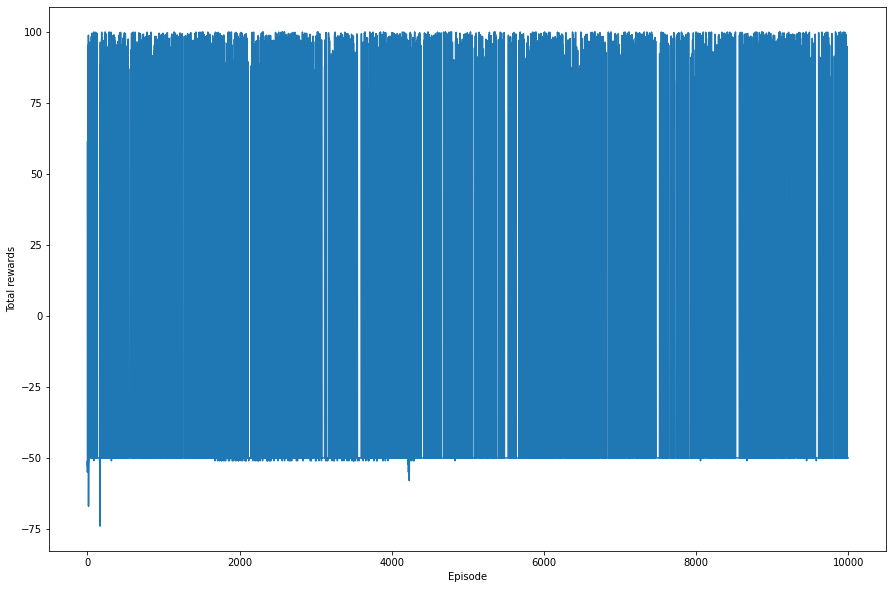

In [10]:
plt.figure(figsize=(15,10))
plt.xlabel("Episode")
plt.ylabel("Total rewards")
plt.plot(reward_list)

In [11]:
def moving_average(data,n):
    len_data=len(data)-n
    res_data=np.zeros(len_data)

    for i in range(len_data):
        res_data[i]=sum(data[i:i+n])/n
    return res_data

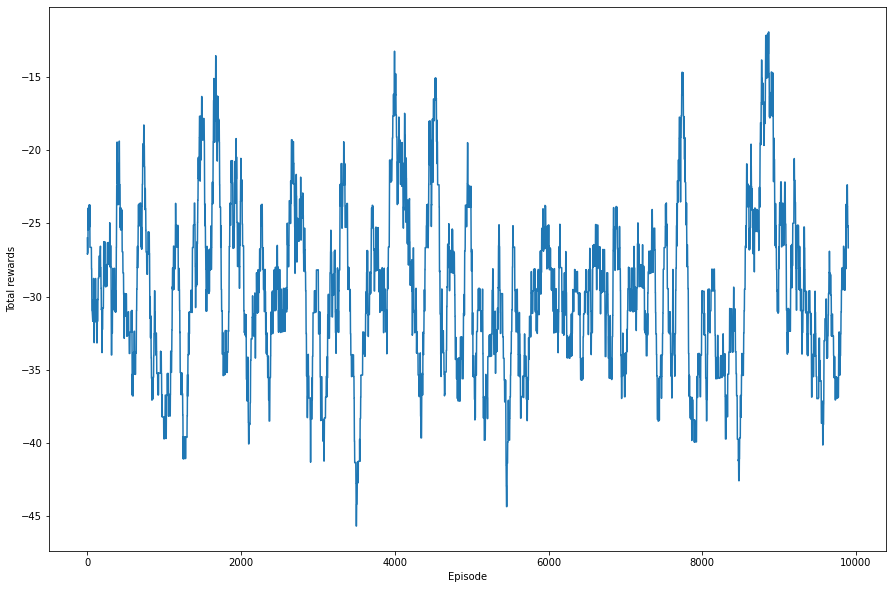

In [18]:
average_number=100
filtered_data=moving_average(reward_list,average_number)
plt.figure(figsize=(15,10))
plt.xlabel("Episode")
plt.ylabel("Total rewards")
plt.plot(filtered_data)

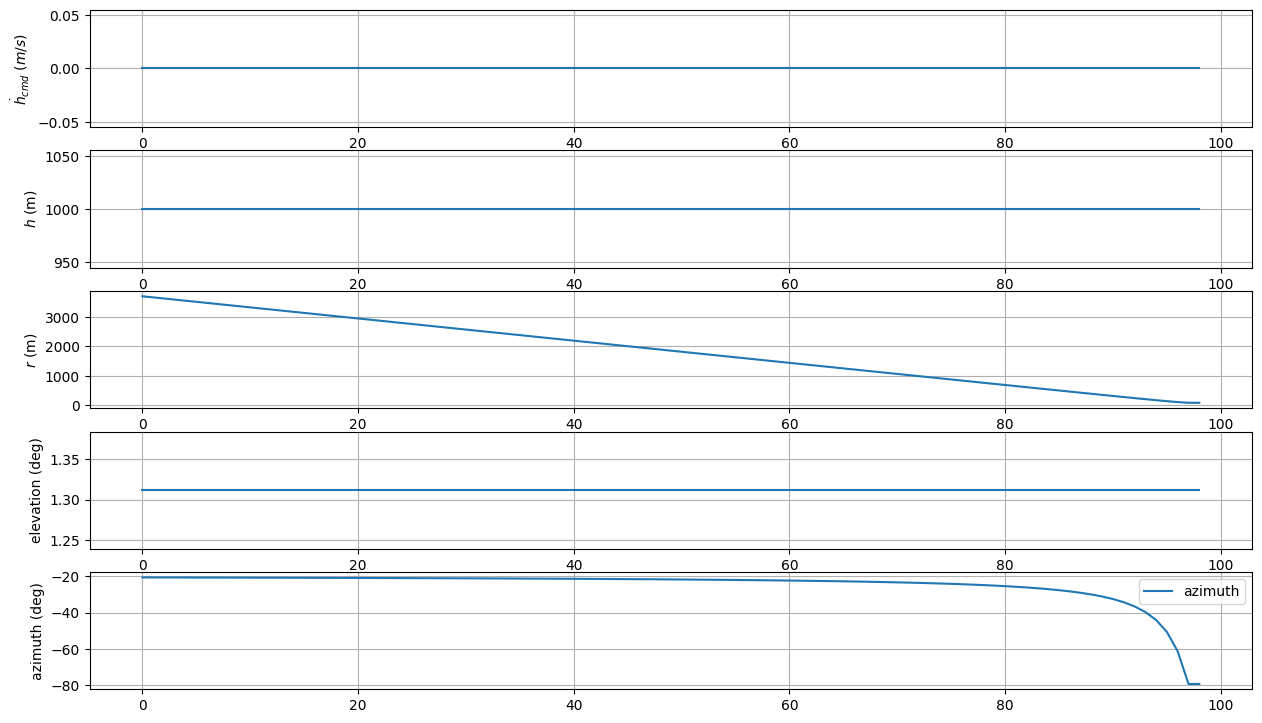

In [19]:
# plots
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[99]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()

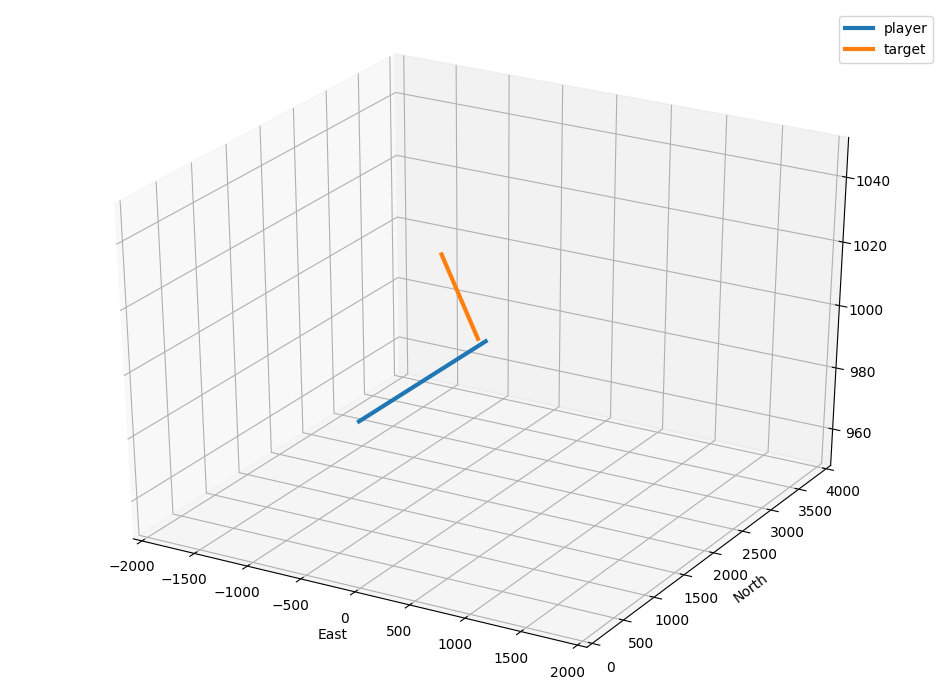

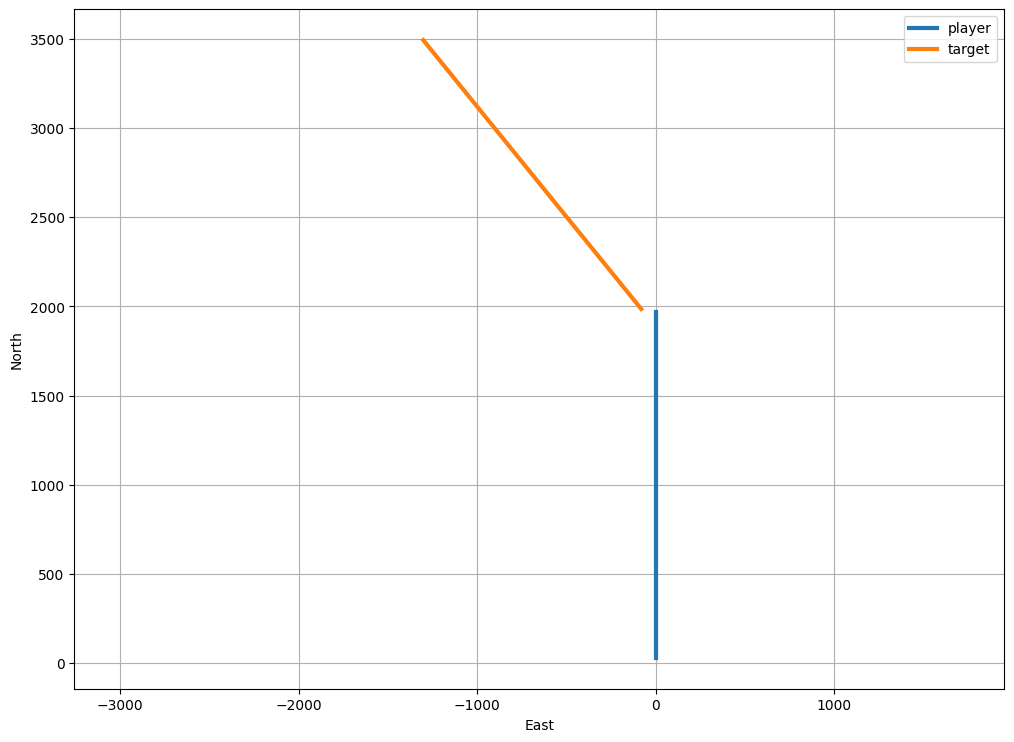

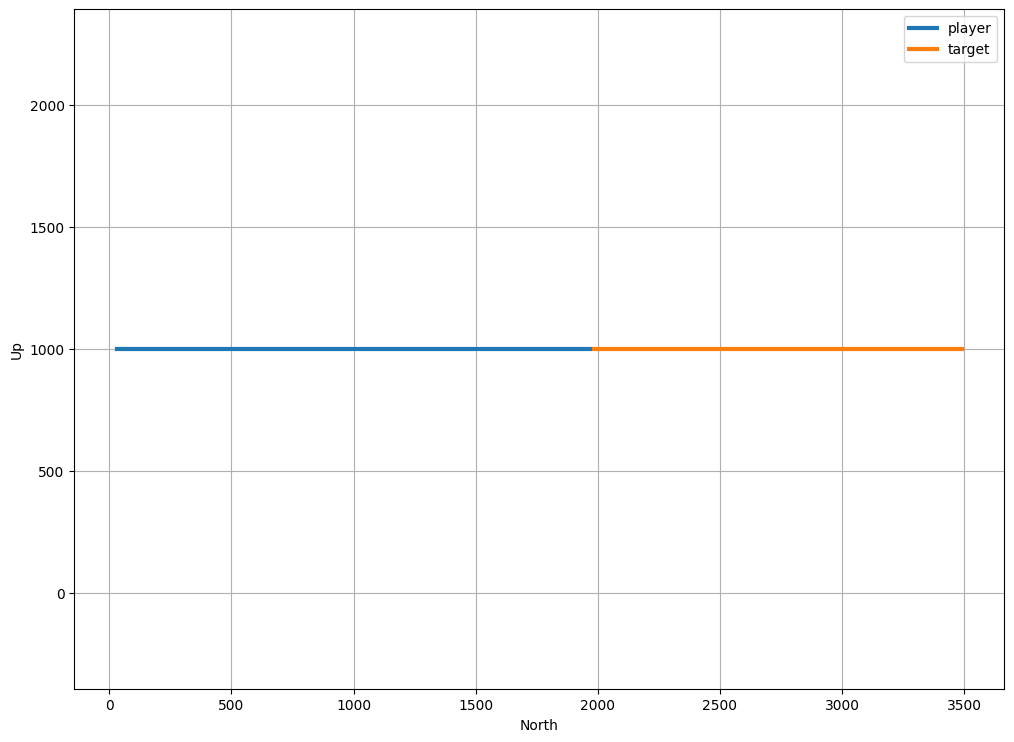

In [20]:
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(plt_res[:,5], plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,5], plt_res[:,4], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('North')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

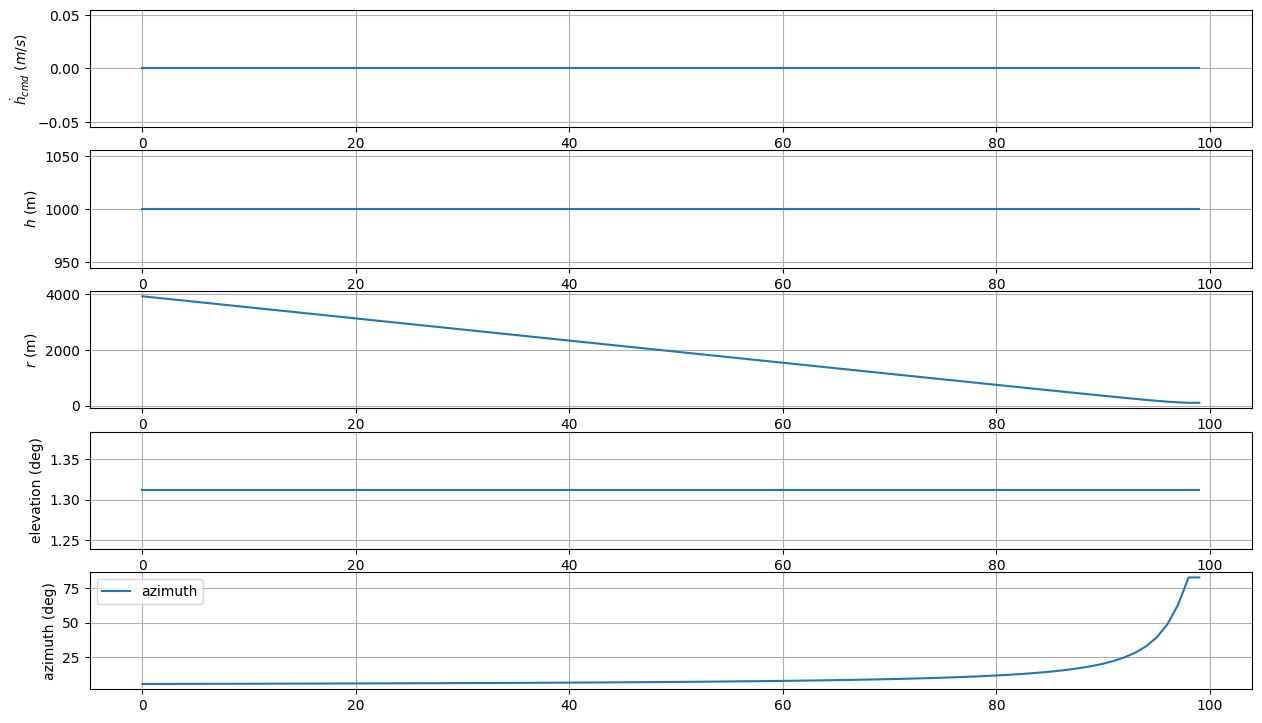

In [21]:
# plots
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[9999]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()

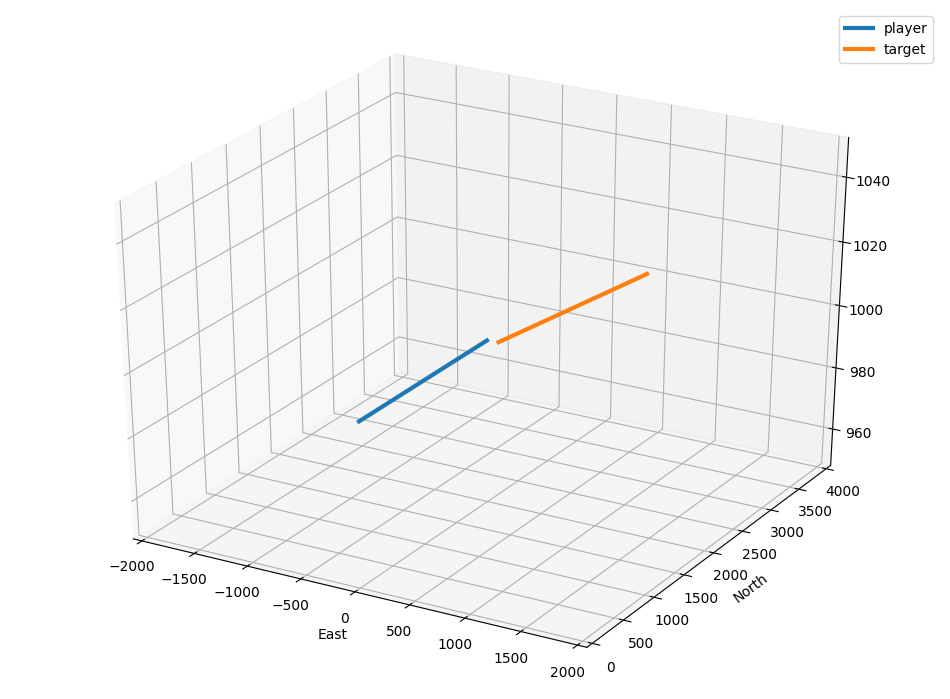

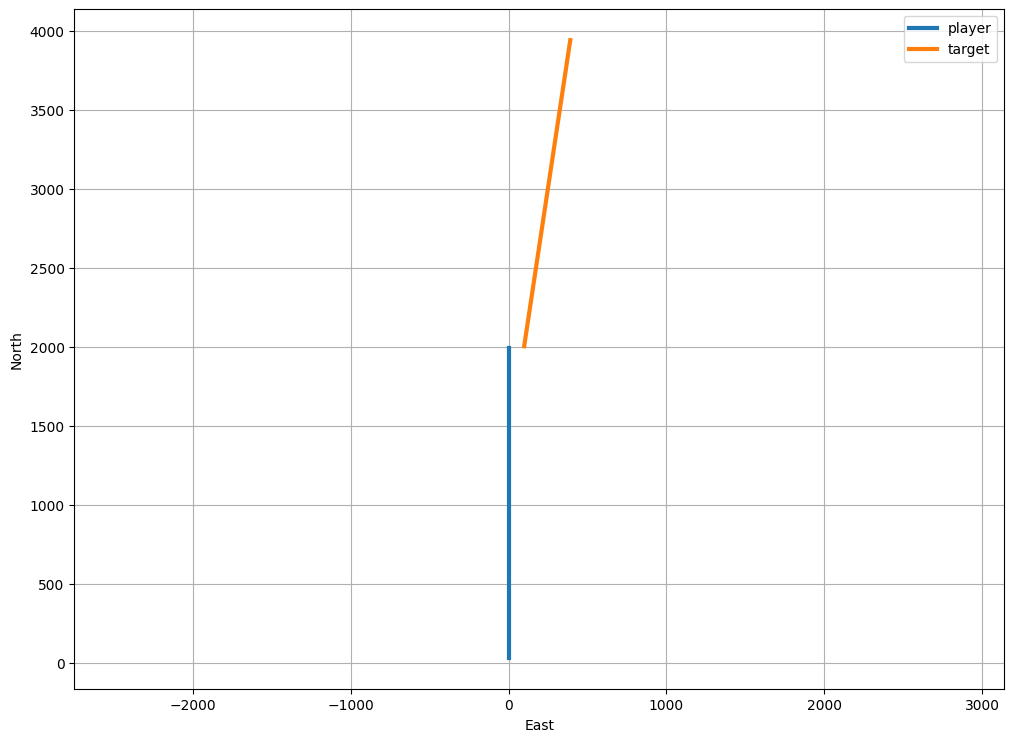

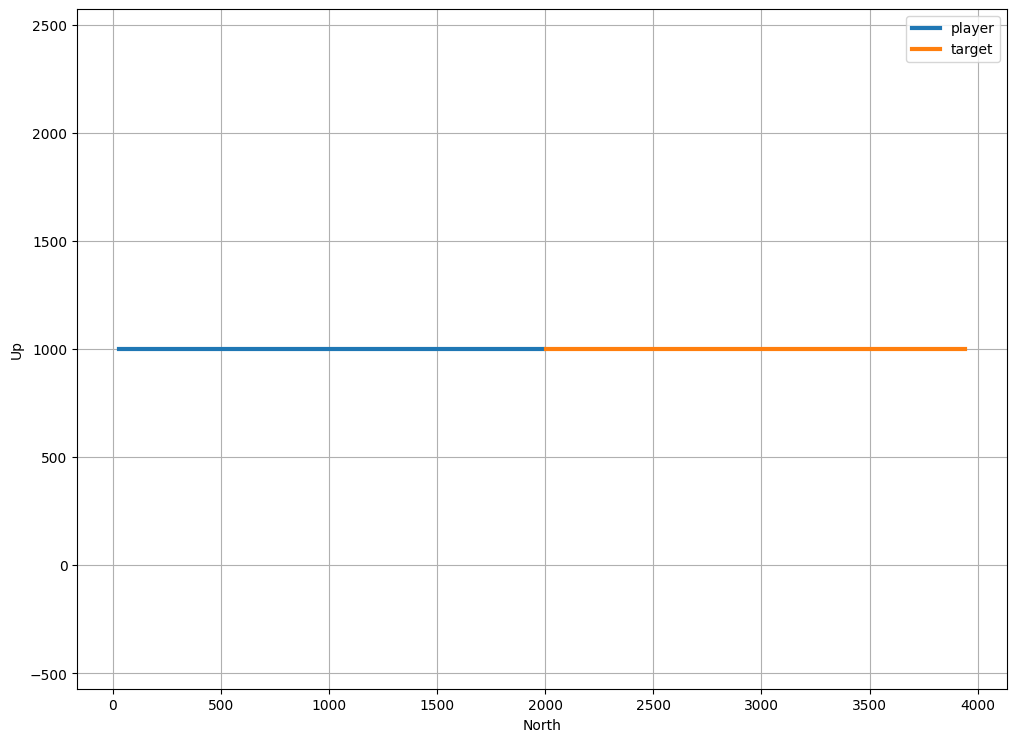

In [22]:
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(plt_res[:,5], plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,5], plt_res[:,4], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('North')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

In [17]:
min(plt_res[:,1])

99.78755156830016